# Домашнее задание 3

*Выполнила Казаченко Екатерина*

In [1]:
# импорт всех необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statannot import add_stat_annotation
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import bootstrap
from scipy.stats import spearmanr

In [5]:
# Чтение файла данных
df = pd.read_csv(
    'asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv')

## Изучение датасета

In [6]:
df.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


In [8]:
df['cell_interaction'].value_counts()

cell_interaction
community_4    80969
community_2    51482
community_1    48516
community_5    34881
community_6    26907
community_3    26687
Name: count, dtype: int64

In [9]:
df['age_group'].value_counts()

age_group
young_group    188900
elder_group     80542
Name: count, dtype: int64

In [10]:
df['cell_type'].value_counts()

cell_type
Stroma cells     173192
Unclassified      66966
Immune type 2     16204
Immune type 1      5575
Blood cells        2818
Bone cells         2555
Largest cells      1988
Vasculature         144
Name: count, dtype: int64

### В датасете есть следующие колонки:

 - distance_to_vasculature — расстояние до ближайших сосудов;
 - distance_to_largest_cell — расстояние до ближайшей крупной клетки;
 - immune_marker_1 — экспрессия иммунного маркера 1 в данной клетке;
 - immune_marker_2 — экспрессия иммунного маркера 2 в данной клетке;
 - cell_type — тип клетки (Stroma cells, Unclassified, Immune type 2, Immune type 1, Blood cells, Bone cells, Largest cells, Vasculature)
 - area_of_cell — размер клетки;
 - case_id — уникальный ID пациента;
 - cell_interaction - клеточное взаимодействие (community_1, community_2, community_3, community_4, community_5, community_6)
 - age_group - возрастная группа (young_group - молодые, elder_group - пожилые)

In [11]:
# Вывод общей статистики по числовым столбцам
print(df.describe())

       distance_to_vasculature  distance_to_largest_cell  immune_marker_1  \
count            269442.000000             269442.000000    269442.000000   
mean                929.070855                763.923963        20.161576   
std                 232.025464                143.529254         8.878973   
min                 576.000265                576.000340         0.022423   
25%                 749.548219                666.386842        14.059163   
50%                 889.336304                731.602653        19.167223   
75%                1067.406152                822.422538        24.883889   
max                2057.201309               3181.140602       119.474602   

       immune_marker_2        case_id   area_of_cell  
count    269442.000000  269442.000000  269442.000000  
mean         77.737352     543.799330     252.588887  
std          62.181699     339.463422     154.717140  
min           0.022770      40.000000      45.000000  
25%          32.423038     199.

In [12]:
# Вывести статистику только по категориальным столбцам
df.describe(include=['object'])

,cell_interaction,cell_type,age_group
count,269442,269442,269442
unique,6,8,2
top,community_4,Stroma cells,young_group
freq,80969,173192,188900


## Подготовка данных 

In [13]:
df_1 = df.copy()

In [14]:
# изучение пропусков
df_1.isnull().sum()

distance_to_vasculature     0
distance_to_largest_cell    0
immune_marker_1             0
immune_marker_2             0
cell_interaction            0
cell_type                   0
case_id                     0
area_of_cell                0
age_group                   0
dtype: int64

In [15]:
# цикл по всем датасетам для поиска дубликатов
dupl_columns = list(df_1.columns)
# булевая маска для фильтрации, subset - список признаков, по которым идет поиск дубликатов
mask = df_1.duplicated(subset=dupl_columns)
# количество дубликатов в текущем датасете
num_duplicates = df_1[mask].shape[0]
if num_duplicates == 0:
    print("Дубликатов нет")

Дубликатов нет


In [16]:
# Преобразование столбца age_group:
# 1 - для молодых young_group, 0 - для пожилых elder_group
df_1['age_group'] = df_1['age_group'].map({'young_group': 1, 'elder_group': 0})

In [17]:
# Преобразование значений в столбце cell_interaction
df_1['cell_interaction'] = df_1['cell_interaction'].replace({
    'community_1': 1,
    'community_2': 2,
    'community_3': 3,
    'community_4': 4,
    'community_5': 5,
    'community_6': 6
})

# Переименование столбца cell_interaction в cell_interaction_community
df_1 = df_1.rename(columns={'cell_interaction': 'cell_interaction_community'})

In [18]:
df_1.sample(3)

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction_community,cell_type,case_id,area_of_cell,age_group
181576,914.721249,815.709819,16.635324,111.253640,4,Stroma cells,693,306,1
38475,1284.867102,784.830038,14.634906,22.653969,1,Stroma cells,199,209,1
178714,962.458402,611.276456,17.373818,25.239093,2,Stroma cells,40,72,0


In [19]:
df_2 = df_1.copy()

## Задание 1a

Есть ли стат-значимость между типом клетки и:

а) Размером клетки (area_of_cell), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

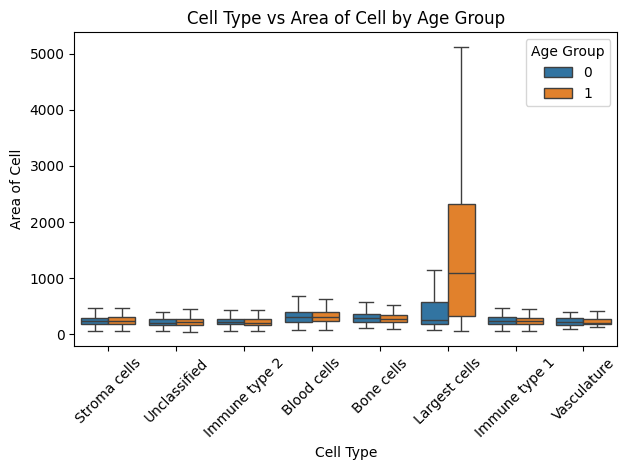

In [20]:
# Создание boxplot с разделением по возрастным группам
sns.boxplot(x='cell_type', y='area_of_cell',
            hue='age_group', data=df_2, showfliers=False)

plt.xticks(rotation=45)
plt.title('Cell Type vs Area of Cell by Age Group')
plt.xlabel('Cell Type')
plt.ylabel('Area of Cell')

plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

Средний размер клеток Largest Cells больше, чем размеры других типов клеток в группе молодых пациентов (группа 1), однако при сравнении разброса значений, можно также предположить о наличии значимой разницы в размере Largest Cells в группе пожилых пациентов (группа 0).

In [21]:
# Создание датасета для молодой возрастной группы (age_group == 1)
df_young = df_2[df_2['age_group'] == 1][['area_of_cell', 'cell_type']]

# Создание датасета для пожилой возрастной группы (age_group == 0)
df_elder = df_2[df_2['age_group'] == 0][['area_of_cell', 'cell_type']]

In [22]:
df_young.head()

,area_of_cell,cell_type
315,261,Stroma cells
316,142,Immune type 2
317,344,Stroma cells
318,170,Stroma cells
319,224,Immune type 1


## Проверка на нормальность с помощью теста Шапиро-Уилка

In [23]:
# тест на нормальность
# Создаем функцию для определения нормальности распределния данных на основе теста Шапиро-Уилка
# Функция прининимает на вход датафрейм, названия столбца зависимой переменной
# и значение альфа, которое по дефолту равно 0.05

def shapiro_test_function(df, col, alpha=0.05):
    H_0 = 'Данные распределены нормально'
    H_1 = 'Данные распределены не нормально'
    print(f'alpha = {alpha}')
    cell_types = df['cell_type'].unique()
    for cell_type in cell_types:
        print(f"Тест на нормальное распределние типа клеток: {cell_type}")
        data = df[df['cell_type'] == cell_type][col]
        __, p_value = shapiro(data)
        print(f"p={p_value:.3f}")
        if p_value > alpha:
            print(H_0)
        else:
            print(f'Мы отвергаем нулевую гипотезу.{H_1}')
        print("")

In [24]:
shapiro_test_function(df_young, 'area_of_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.001
Мы отвергаем

c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
shapiro_test_function(df_elder, 'area_of_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем

Вывод: по результатам теста Шапиро-Уилка все данные имеют не нормальное распределение.

## Проверка гомогенности дисперсий с помощью теста Левена:

In [26]:
# тест на гомогенность Левена
# Создаем функцию для определения гомогенности распределния данных на основе теста Левена
# Функция прининимает на вход датафрейм, названия столбца зависимой переменной
# и значение альфа, которое по дефолту равно 0.05

def levene_function(df, col, alpha=0.05):
    H_0 = 'Данные распределены гомогенно. Дисперсии во всех группах равны'
    H_1 = 'Данные распределены не гомогенно. Существует различие в дисперсиях между выборками'
    cell_types = df['cell_type'].unique()
    groups = [df[df['cell_type'] == cell_type][col]
              for cell_type in cell_types]

    __, p = levene(*groups)
    print('p=%.5f' % p)
    print(f'alpha = {alpha}')

    if p > alpha:
        print(H_0)
    else:
        print(f'Мы отвергаем нулевую гипотезу.{H_1}')
        print("")

In [27]:
levene_function(df_elder, 'area_of_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [28]:
levene_function(df_young, 'area_of_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



Вывод: по результатам теста на гомогенность распределения Левена в обеих выборках данные распределены негомогенно.

## Размер выборок

In [29]:
print(f'Размер первой выборки: {df_young.shape}')
print(f'Размер второй выборки: {df_elder.shape}')

Размер первой выборки: (188900, 2)
Размер второй выборки: (80542, 2)


## Вывод

Таким образом, в наших выборках:

 - данные распределены ненормально по результатам теста Шапиро-Уилка и негомогенно по результатам теста Левена. Одна из переменных является числовой (area_of_cell), другая категориальной (cell_type). 

 - Объем выборки достаточно большой (для молодых пациентов - 188900, для пожилых - 80542).

 - Выборки независимые и не связанные между собой.

 - Имеются выбросы

### Таким образом, можно выбрать непараметрический [тест Краскела-Уоллиса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

Критерий Краскела-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех или более независимых групп, он является непараметрическим эквивалентом однофакторного дисперсионного анализа и обычно используется, когда нарушается предположение о нормальности. Критерий Краскела-Уоллиса гораздо менее чувствителен к выбросам, чем однофакторный дисперсионный анализ.

Для проведения этого теста необходимы следующие условия: 

1. Порядковая или непрерывная переменная - она у нас есть, это размер клетки

2. Независимость – наблюдения в каждой группе должны быть независимыми друг от друга - также соблюдается в нашем случае, так как типы клеток и их размеры составляют отдельные непересекающиеся категории.

3. Распределения имеют сходную форму — распределения в каждой группе должны иметь одинаковую форму - по результату теста на гомогенность дисперсий у нас распрделение не равномерное. 

## Тест Краскела — Уоллиса

In [30]:
# тест Краскела — Уоллиса
# Создаем функцию для статистически значимой разницы между типом клетки и размером клетки по возрастным группам.
# Функция прининимает на вход датафрейм и значение альфа, которое по дефолту равно 0.05

def kruskal_function(df, col, alpha=0.05):
    H_0 = 'Статистически значимой разницы между группами нет'
    H_1 = 'Статистически значимая разница между группами есть'
    cell_types = df['cell_type'].unique()
    groups = [df[df['cell_type'] == cell_type][col]
              for cell_type in cell_types]

    stat, p = kruskal(*groups)
    print('p=%.5f' % p)
    print(f'alpha = {alpha}')
    if p > alpha:
        print(H_0)
    else:
        print(f'Мы отвергаем нулевую гипотезу.{H_1}')

In [31]:
kruskal_function(df_young, 'area_of_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [32]:
kruskal_function(df_elder, 'area_of_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


Вывод: По результатам теста Краскела-Уоллиса в обеих возрастных группах есть статистически значимая разница между типом клетки и размером клетки. Результаты теста также подтверждаются графиком боксплот, где видно, что размеры клеток Largest Cells значимо отклонялись от показателей других типов клеток в обеих возрастных группах.

В данном тесте использовались обобщенные данные для поиска статистической разницы, то есть считалась разница в общей выборке по всем клеткам сразу. Однако, на основе этого теста мы не можем сказать, размер каких клеток действительно был значимо больше/меньше других. С помощью графика нам удалось сделать предположение о том, что значимо отклоняющейся группой могли быть клетки Largest Cells. Для одноначного ответа также можно было попарно сравнить все типы клеток между собой, но в рамках задания этого не требовалось сделать. 

Также перед данным тестом мы не делали поиск и удаление выбросов, что могло повлиять на распределение данных и получения ненормального и негомогенного распределения во всех выборках. При правильной предобработке и работе с выбросами, возможно, мы бы получили нормальное распрделение, в таком случае, использовали бы однофакторный анализ ANNOVA для поиска статистически значимых отличий. 

Также, можно заметить, что в предоставленном датасете достаточно небольшое количество пациентов, при этом мы не знаем о том, насколько гомогенны эти пациенты по клинической картине и стадии заболевания, что также могло повлиять на наши расчеты. 

Ограничениями теста Краскела-Уоллиса являются:

 * Нечувствительность к распределению: Тест предполагает, что все группы имеют одинаковую форму распределения, но различаются только по медианам. Если формы распределения значительно отличаются, это может повлиять на результаты теста.

Проверку распределения можно сделать как раз по графику боксплот. На нашем графике мы видим, что все клетки, кроме Largest Cells, имеют одинаковое распрделение. На онове этих данных и для проведения более точного анализа, мы могли бы исключить эту группу из общей выборки и сравнить ее отдельно. 

 * Игнорирование величины различий: тест не учитывает величину различий между группами, только их ранги.

По нашему графику боксплот мы можем заметить, что размеры клеток Largest Cell (особенно в группе пожилых), имеют величину в 2-3 раза больше, чем другие клетки, что также могло повлять на результат. 

 * Влияние выбросов: Как и большинство непараметрических тестов, тест Краскела-Уоллиса более устойчив к выбросам, чем параметрические тесты, но всё же серьезные выбросы могут оказать влияние на ранги и исказить результаты.

 * Отсутствие информации о парных сравнениях: Тест может указать, что по крайней мере одна группа значительно отличается от других, но не указывает, какие именно группы отличаются. И как уже было написано выше, мы можем лишь обобщенно сказать, что в какой-либо выборке есть статистически значимые различия без указаний конкретных групп.

В качестве возможных улучшений для проведения теста, можно рассмотреть проведение пост-хок анализа с поправкой на множественные сравнения (например, метод Данна) для определения пар групп с различиями.

Для оценки значимости и величины эффектов теста Краскела-Уоллиса можно также провести оценку:

1. Эффектного размера (мера величины различий между группами), например, с помощью статистики, подобную критерию η² (эта квадрат) 
```
(H - (k - 1)) / (N - k)
```
где H — значение статистики Краскела-Уоллиса, k — количество групп, а N — общее количество наблюдений. Это даст представление о том, насколько сильно группы отличаются друг от друга.

2. с помощью пост-хок тестов (описано выше)

3. доверительных интервалов для медиан или средних рангов каждой группы. Если они не пересекаются, это указывает на более значимые различия между группами.

4. с помощью визуализации данных - в нашем анализе мы это проводили.

5. средних рангов, которые использовались в тесте Краскела-Уоллиса

6. с помощью создания графиков кумулятивной вероятности для каждой группы может помочь понять распределение данных и различия между группами.

При проведении множественных статистических тестов необходимо провдить корректировку уровня значимости для контроля над ошибками I типа, связанными с множественными сравнениями. Использование поправки Бонферрони или других методов коррекции может помочь уменьшить вероятность ложноположительных результатов.

С точки зрения прикладного клинического значения полученные результаты в целом не сильно информативны. Мы получили, что статистическая разница в размере клеток есть как в группе молодых, так пожилых пациентов. Однако, по названию клеток (Largest Cells - с англ. самый большие клетки) можно уже предположить, что они имеют самый большой размер. Если бы мы провели дополнительные сравнения подгрупп по типам клеток и получили бы, что действительно только Largest Cells имеет значимо бОльший размер клеток по сравнению с другими, то могли бы тогда сказать, что размер - достоверное отличие этих клеток от других. Помимо этого, было бы полезно с клинической точки зрения рассчитать доверительные интервалы, чтобы в дальнешем при дифференцировки клеток мы могли опираться на такой критерий, как размер. 

Для дополнительной оценки значимости и величины эффектов построим доверительные интервалы в каждой выборке для каждого типа клеток

In [33]:
# Функция для расчета довреительного интервала выборки по каждому типу клеток
# На вход приниается соответствующий датасет

def calculate_confidence_intervals(df, column_group, column_data, confidence_level=0.95, n_resamples=100):
    def median_func(data):
        return np.median(data)

    # Уникальные значения типов клеток
    unique_groups = df[column_group].unique()

    for group in unique_groups:
        group_data = df[df[column_group] == group][column_data].to_numpy()
        # Расчет доверительных интервалов
        if len(group_data) > 1:
            confidence_interval = bootstrap((group_data,), median_func,
                                            method='percentile',
                                            confidence_level=confidence_level,
                                            n_resamples=n_resamples).confidence_interval
            formatted_interval = f"[{confidence_interval.low:.2f}, {confidence_interval.high:.2f}]"
            print(
                f"Тип клеток: {group}, {confidence_level*100:.0f}% доверительный интервал для медианы: {formatted_interval}")
        else:
            print(
                f"Тип клеток: {group}, не достаточно данных для расчета доверителеьного интервала.")

In [34]:
calculate_confidence_intervals(
    df_young, 'cell_type', 'area_of_cell', n_resamples=100)

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [238.00, 240.00]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [203.47, 208.00]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [224.00, 231.00]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [213.00, 215.00]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [919.00, 1254.53]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [309.00, 319.52]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [271.24, 281.00]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [186.47, 244.52]


Как видно, в выборке с молодыми пациентами доверительные интервалы клеток Stroma cells, Immune type 2,  Immune type 1, Unclassified, Largest cells, Blood cells, Bone cells достаточно небольшие и не пересекаются между собой. Доверительный интервал клеток Vasculature шире и пересекается с несколькими другими типами клеток. Также, стоит отметить, что размеры клеток Largest cells в 3-4 раза больше, чем у других и доверительный интервал у них тоже самый большой. 

Таким образом, между теми интервалами, которые не пересекаются, как раз и могла быть статистически значимая разница. 

In [35]:
calculate_confidence_intervals(df_elder,  'cell_type', 'area_of_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [228.00, 230.00]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [209.00, 211.00]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [218.00, 222.00]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [288.95, 316.52]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [281.00, 308.05]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [250.00, 271.52]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [232.43, 244.00]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [209.00, 248.50]


Как видно, в выборке с молодыми пациентами доверительные интервалы клеток Stroma cells, Immune type 2,  Immune type 1, Unclassified, Largest cells достаточно небольшие и не пересекаются между собой. Доверительный интервал клеток Bone cells с Blood cells пересекается друг с другом. Доверительный интервал клеток Vasculature имеет более широкий интервал по сравнению с другими и пересекается с Immune type 2, Immune type 1, Unclassified и Stroma cells. 

Также, стоит отметить, что в данной выборке пожилых пациентов размеры клеток Largest cells и их доверительный интервал не сильно отличаются от других клеток (интервал узкий и размеры клеток не превышают в разы другие клетки). 

Таким образом, между теми интервалами, которые не пересекаются, как раз и могла быть статистически значимая разница. 

## Задание 1б

Есть ли стат-значимость между типом клетки и:

б) Экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

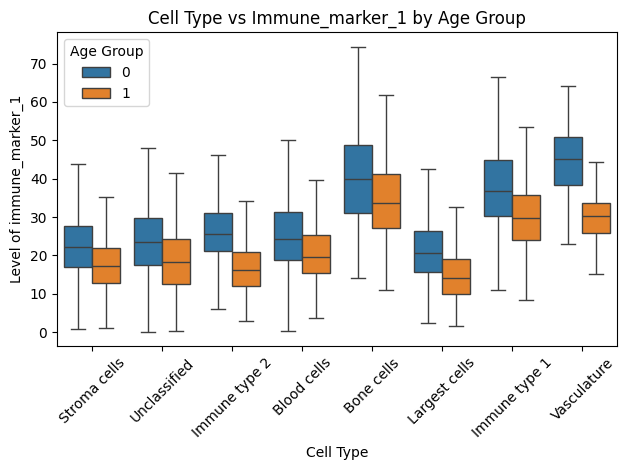

In [36]:
# Создание boxplot с разделением по возрастным группам для уровня иммунного маркера 1
sns.boxplot(x='cell_type', y='immune_marker_1',
            hue='age_group', data=df_2, showfliers=False)

plt.xticks(rotation=45)
plt.title('Cell Type vs Immune_marker_1 by Age Group')
plt.xlabel('Cell Type')
plt.ylabel('Level of immune_marker_1')

plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

При сравнении медиан экспрессии иммунного маркера 1 можно лишь предположить, что в среднем клетки Bone cells, Immune type 1 и Vasculature имеют более высокую экспрессию данного маркера, при этом экспрессия во всех типах клеток выше у пожилых пациентов (группа 0).

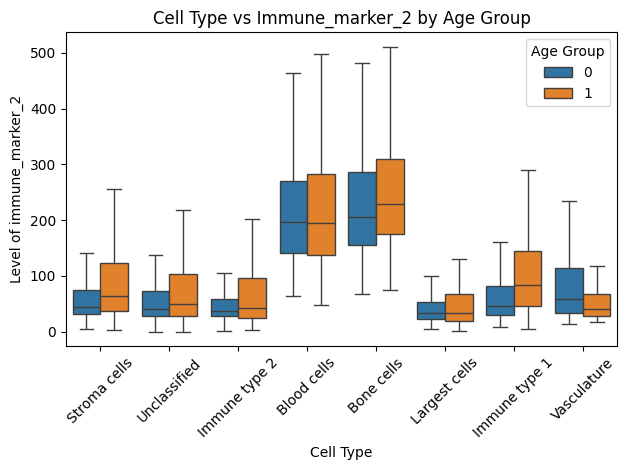

In [37]:
# Создание boxplot с разделением по возрастным группам для уровня иммунного маркера 2
sns.boxplot(x='cell_type', y='immune_marker_2',
            hue='age_group', data=df_2, showfliers=False)

plt.xticks(rotation=45)
plt.title('Cell Type vs Immune_marker_2 by Age Group')
plt.xlabel('Cell Type')
plt.ylabel('Level of immune_marker_2')

plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

При сравнении медиан экспрессии иммунного маркера 2 можно лишь предположить, что в среднем клетки Bone cells и Blood Cells имеют более высокую экспрессию данного маркера в обеих ворастных группах.

In [38]:
# Создание датасета для молодой возрастной группы (age_group == 1) и иммунного маркера 1
df_young_marker_1 = df_2[df_2['age_group'] == 1][
    ['immune_marker_1', 'cell_type']]

# Создание датасета для молодой возрастной группы (age_group == 1) и иммунного маркера 2
df_young_marker_2 = df_2[df_2['age_group'] == 1][
    ['immune_marker_2', 'cell_type']]

# Создание датасета для пожилой возрастной группы (age_group == 0) и иммунного маркера 1
df_elder_marker_1 = df_2[df_2['age_group'] == 0][
    ['immune_marker_1', 'cell_type']]

# Создание датасета для пожилой возрастной группы (age_group == 0) и иммунного маркера 2
df_elder_marker_2 = df_2[df_2['age_group'] == 0][
    ['immune_marker_2', 'cell_type']]

In [39]:
df_young_marker_2.head(3)

,immune_marker_2,cell_type
315,133.223933,Stroma cells
316,49.971129,Immune type 2
317,42.974851,Stroma cells


## Проверка на нормальность с помощью теста Шапиро-Уилка

In [40]:
shapiro_test_function(df_young_marker_1, 'immune_marker_1')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем

c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
shapiro_test_function(df_young_marker_2, 'immune_marker_2')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем

In [42]:
shapiro_test_function(df_elder_marker_1, 'immune_marker_1')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.061
Данные распределены нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем нулевую гипотезу.Данные распреде

In [43]:
shapiro_test_function(df_elder_marker_2, 'immune_marker_2')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем

Вывод: по результатам теста Шапиро-Уилка все данные имеют не нормальное распределение, кроме распределения уровня иммунного маркера 1 для клеток  Bone cells в группе пожилых пациентов.

## Проверка гомогенности дисперсий с помощью теста Левена:

In [44]:
levene_function(df_young_marker_1, 'immune_marker_1')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [45]:
levene_function(df_young_marker_2, 'immune_marker_2')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [46]:
levene_function(df_elder_marker_1, 'immune_marker_1')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [47]:
levene_function(df_elder_marker_2, 'immune_marker_2')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



Вывод: по результатам теста на гомогенность распределения Левена во всех выборках данные распределены негомогенно.

## Размер выборок

In [48]:
print(f'Размер первой выборки: {df_young_marker_1.shape}')
print(f'Размер второй выборки: {df_young_marker_2.shape}')
print(f'Размер третьей выборки: {df_elder_marker_1.shape}')
print(f'Размер четвертой выборки: {df_elder_marker_2.shape}')

Размер первой выборки: (188900, 2)
Размер второй выборки: (188900, 2)
Размер третьей выборки: (80542, 2)
Размер четвертой выборки: (80542, 2)


## Вывод

Таким образом, в наших выборках:

 - данные распределены ненормально по результатам теста Шапиро-Уилка и негомогенно по результатам теста Левена. Одна из переменных является числовой (уровень иммунного маркера), другая категориальной (cell_type). 

 - Объем выборки достаточно большой (для молодых пациентов - 188900, для пожилых - 80542).

 - Выборки, разделенные по возрасту, независимые и не связанные между собой. А выборки, разделенные на уровень содержания иммунного маркера 1 и 2 - связанные, так как эти данные получены от одних и тех же пациентов (у одного пациента замерялся уровень обоих иммунных маркеров).

 - имеются выбросы

### Таким образом, можно выбрать непараметрический [тест Краскела-Уоллиса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

Критерий Краскела-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех или более независимых групп, он является непараметрическим эквивалентом однофакторного дисперсионного анализа и обычно используется, когда нарушается предположение о нормальности. Критерий Краскела-Уоллиса гораздо менее чувствителен к выбросам, чем однофакторный дисперсионный анализ.

Для проведения этого теста необходимы следующие условия: 

1. Порядковая или непрерывная переменная - она у нас есть, это уровень экспрессии иммунных маркеров 1 и 2

2. Независимость – наблюдения в каждой группе должны быть независимыми друг от друга - также соблюдается в нашем случае мы будем сравнивать группы, разделенные по возрасту и по типу иммунномого маркера, поэтому внутри каждой выборки не будет зависмых групп.

3. Распределения имеют сходную форму — распределения в каждой группе должны иметь одинаковую форму - по результату теста на гомогенность дисперсий у нас распределение не равномерное. 

## Тест Краскела — Уоллиса

In [49]:
kruskal_function(df_young_marker_1, 'immune_marker_1')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [50]:
kruskal_function(df_young_marker_2, 'immune_marker_2')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [51]:
kruskal_function(df_elder_marker_1, 'immune_marker_1')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [52]:
kruskal_function(df_elder_marker_2, 'immune_marker_2')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


Вывод: По результатам теста Краскела-Уоллиса в обеих возрастных группах есть статистически значимая разница между типом клетки и уровнем экспрессии иммунного маркера 1 и 2. Результаты теста также подтверждаются графиком боксплот, где видно, что типы клеток Bone cells, Immune type 1 и  Vasculature имеют в среднем более высокую экспрессию иммунного маркера 1 в обеих возрастных группах, а экспрессия иммунного маркера 2 выше в Blood Cells и Bone Cells также в обеих возрастных группах.

С точки зрения прикладного клинического значения полученные результаты в целом не сильно информативны, так как в данном тесте использовались обобщенные данные для поиска статистической разницы, то есть считалась разница в выборке по всем типам клеткок сразу, поэтому на основе этого теста мы не можем сказать, экспрессия в каких конкретно клетках была значимо выше, чем в других. С помощью графика нам удалось сделать предположение о том, в каких клетках экспрессия выше, но опять же, точно определить группы мы не можем. Для одноначного ответа необходимо попарно сравнить все типы клеток между собой по уровню экспрессии иммунного маркера 1 и 2. Однако, зачастую на первых этапах исследования, достаточно будет ответить на вопрос, есть ли разница в целом, чтобы в дальнейшем заниматься этим вопросом более подробно. 

Также, можно заметить, что в предоставленном датасете достаточно небольшое количество пациентов, при этом мы не знаем о том, насколько гомогенны эти пациенты по клинической картине и стадии заболевания, что также могло повлиять на наши расчеты. Эти данные помогли бы соотнести уровень экспресии того или иного маркера и стадию заболевания.

Ограничения теста Краскела-Уоллиса (кратко, так как уже были описаны в задании 1а)

 * Нечувствительность к распределению: в целом по нашим графикам боксплот можно предположить о более менее одинаковом распределении в группах.

 * Игнорирование величины различий 

 * Влияние выбросов: перед данным тестом мы не делали поиск и удаление выбросов, что могло повлиять на распределение данных и получения ненормального и негомогенного распределения во всех выборках. 

 * Отсутствие информации о парных сравнениях (описано выше, что мы получили лишь обобщенные данные без указания на конкретные группы)

В качестве возможных улучшений для проведения теста, можно рассмотреть проведение пост-хок анализа с поправкой на множественные сравнения (например, метод Данна) для определения пар групп с различиями.

Для оценки значимости и величины эффектов теста Краскела-Уоллиса можно также провести оценку (кратко, так как было описано в задании 1а):

1. Эффектного размера 

2. с помощью пост-хок тестов (описано выше)

3. доверительных интервалов для медиан или средних рангов каждой группы

4. с помощью визуализации данных - в нашем анализе мы это проводили.

5. средних рангов, которые использовались в тесте Краскела-Уоллиса

6. с помощью создания графиков кумулятивной вероятности для каждой группы может помочь понять распределение данных и различия между группами.

При проведении множественных статистических тестов необходимо провдить корректировку уровня значимости для контроля над ошибками I типа, связанными с множественными сравнениями. Использование поправки Бонферрони или других методов коррекции может помочь уменьшить вероятность ложноположительных результатов. 

Для дополнительной оценки значимости и величины эффектов построим доверительные интервалы в каждой выборке для каждого типа клеток

In [53]:
calculate_confidence_intervals(
    df_young_marker_1, 'cell_type', 'immune_marker_1')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [17.31, 17.38]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [16.15, 16.46]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [29.33, 30.02]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [18.07, 18.30]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [13.37, 14.55]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [19.30, 20.08]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [32.85, 34.13]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [27.65, 31.68]


По результатам видно, что в выборке молодых пациентов больше всего экспрессия иммунного маркера 1 наблюдается в клетках Bone cells. При этом все доверительные интервалы не пересекаются между собой, соответственно, можно говорить о значимых различиях между всеми группами.

In [54]:
calculate_confidence_intervals(
    df_elder_marker_1, 'cell_type', 'immune_marker_1')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [22.07, 22.23]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [23.30, 23.56]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [25.48, 25.90]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [23.33, 25.26]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [38.36, 41.06]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [20.11, 21.36]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [35.96, 37.44]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [42.92, 47.86]


По результатам видно, что в выборке пожилых пациентов больше всего экспрессия иммунного маркера 1 наблюдается в клетках Vasculature. Доверительные интервалы клеток Blood cells и Unclassified пересекаются, остальные не пересекаются друг с другом, соответственно, можно говорить о значимых различиях именно между этими группами.
Также, сравнивая выборку пожилых и молодых пациентов по типам клеток можно заметить, что в выборке пожилых пациентов доверительные интервалы у всех типов клеток больше по величине значениям и не пересекаются между выборками следовательно, у пожилых пациентов экспрессия маркера 1 клетками больше. 

In [55]:
calculate_confidence_intervals(
    df_young_marker_2, 'cell_type', 'immune_marker_2')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [63.07, 64.14]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [40.97, 43.06]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [81.70, 87.75]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [48.86, 49.96]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [31.27, 35.36]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [189.78, 199.43]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [223.75, 233.53]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [33.08, 53.94]


По результатам видно, что в выборке молодых пациентов больше всего экспрессия иммунного маркера 2 наблюдается в клетках Bone cells, превышая другие значения в 4-5 раз. При этом все доверительные интервалы, кроме Vasculature не пересекаются между собой и являются достаточно узкими, соответственно, можно говорить о значимых различиях между всеми группами. Доверительные интервалы Vasculature широкие (по сравнению с другими) и пересекаются с клетками Unclassified и Immune type 2, можно предположить что между ними нет значимой разницы. 

In [56]:
calculate_confidence_intervals(
    df_elder_marker_2, 'cell_type', 'immune_marker_2')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [44.81, 45.39]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [40.19, 40.98]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [36.10, 37.01]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [186.82, 207.59]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [193.24, 225.51]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [31.70, 35.15]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [43.91, 47.69]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [47.29, 74.19]


По результатам видно, что в выборке пожилых пациентов больше всего экспрессия иммунного маркера 2 наблюдается в клетках Blood cells и Bone cells и их доверительные интервалы пересекаются. Доверительные интервалы клеток Unclassified, Immune type 2 и Largest cells не пересекаются ни с кем, остальные пересекаются друг с другом. 

Также, сравнивая выборку пожилых и молодых пациентов по типам клеток можно заметить, что в выборке молодых пациентов доверительные интервалы у Stroma cells, Unclassified, Immune type 2 и Immune type 1 клеток больше по величине значениям и не пересекаются между выборками следовательно, у молодых пациентов экспрессия маркера 2 этими клетками больше. 

## Задание 1в

Есть ли стат-значимость между типом клетки и:

в) Дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

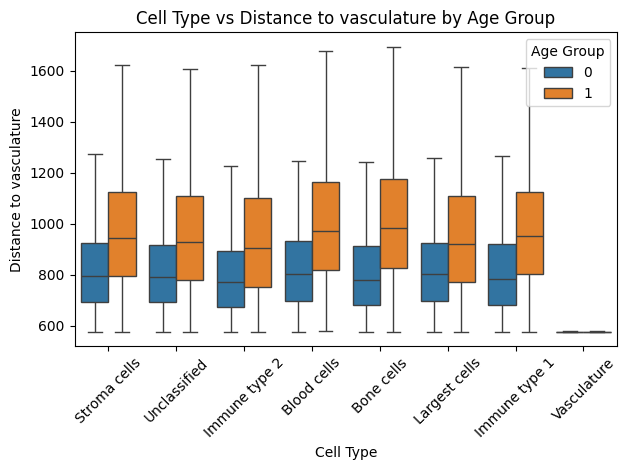

In [57]:
# Создание boxplot с разделением по возрастным группам для расстояния до ближайших сосудов
sns.boxplot(x='cell_type', y='distance_to_vasculature',
            hue='age_group', data=df_2, showfliers=False)

plt.xticks(rotation=45)
plt.title('Cell Type vs Distance to vasculature by Age Group')
plt.xlabel('Cell Type')
plt.ylabel('Distance to vasculature')

plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

На графике явно видно, что расстояние от клеток Vasculature до Vasculature практически на 0, так как в данном параметре как раз и измерялось расстояние других клеток до Vasculature. В дальнейшем анализе данная группа будет удалена, так как она не имеет смысла.

Также заметно, что в молодой возрастной группе (категория 1) в среднем расстояние остальных типов клеток до Vasculature имеет большее среднее значение и больший разброс, чем в группе пожилых пациентов. 

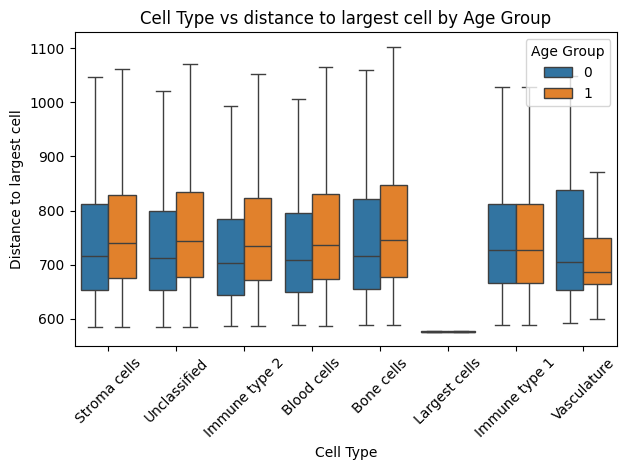

In [58]:
# Создание boxplot с разделением по возрастным группам для расстояния до ближайшей крупной клетки
sns.boxplot(x='cell_type', y='distance_to_largest_cell',
            hue='age_group', data=df_2, showfliers=False)

plt.xticks(rotation=45)
plt.title('Cell Type vs distance to largest cell by Age Group')
plt.xlabel('Cell Type')
plt.ylabel('Distance to largest cell')

plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

На графике явно видно, что расстояние от клеток Largest cells до Largest cells практически на 0, так как в данном параметре как раз и измерялось расстояние других клеток до Largest cells. В дальнейшем анализе данная группа будет удалена, так как она не имеет смысла.

Здесь менее очевидно, что в молодой возрастной группе (категория 1) расстояние остальных типов клеток до Largest cells имеет чуть большее значение и чуть больший разброс, чем в группе пожилых пациентов, и только для нескольких групп. Для проверки статистически значимой разницы необходим статистический тест. 

In [59]:
# Создание датасета для молодой возрастной группы (age_group == 1) и расстояния до ближайших сосудов
df_young_dist_to_vasc = df_2[df_2['age_group'] == 1][
    ['distance_to_vasculature', 'cell_type']]
df_young_dist_to_vasc = df_young_dist_to_vasc[
    df_young_dist_to_vasc['cell_type'] != 'Vasculature']

# Создание датасета для молодой возрастной группы (age_group == 1) и расстояния до ближайшей крупной клетки
df_young_dist_to_larg = df_2[df_2['age_group'] == 1][
    ['distance_to_largest_cell', 'cell_type']]
df_young_dist_to_larg = df_young_dist_to_larg[
    df_young_dist_to_larg['cell_type'] != 'Largest cells']

# Создание датасета для пожилой возрастной группы (age_group == 0) и расстояния до ближайших сосудов
df_elder_dist_to_vasc = df_2[df_2['age_group'] == 0][
    ['distance_to_vasculature', 'cell_type']]
df_elder_dist_to_vasc = df_elder_dist_to_vasc[
    df_elder_dist_to_vasc['cell_type'] != 'Vasculature']

# Создание датасета для пожилой возрастной группы (age_group == 0) и расстояния до ближайшей крупной клетки
df_elder_dist_to_larg = df_2[df_2['age_group'] == 0][
    ['distance_to_largest_cell', 'cell_type']]
df_elder_dist_to_larg = df_elder_dist_to_larg[
    df_elder_dist_to_larg['cell_type'] != 'Largest cells']

In [60]:
df_young_dist_to_vasc.head(3)

,distance_to_vasculature,cell_type
315,634.200203,Stroma cells
316,610.444296,Immune type 2
317,782.995484,Stroma cells


In [61]:
df_young_dist_to_vasc['cell_type'].value_counts()

cell_type
Stroma cells     127408
Unclassified      43231
Immune type 2      8647
Immune type 1      3992
Blood cells        2297
Bone cells         2164
Largest cells      1109
Name: count, dtype: int64

## Проверка на нормальность с помощью теста Шапиро-Уилка

In [62]:
shapiro_test_function(df_young_dist_to_vasc, 'distance_to_vasculature')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [63]:
shapiro_test_function(df_young_dist_to_larg, 'distance_to_largest_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



In [64]:
shapiro_test_function(df_elder_dist_to_vasc, 'distance_to_vasculature')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Largest cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



In [65]:
shapiro_test_function(df_elder_dist_to_larg, 'distance_to_largest_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Unclassified
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Blood cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Bone cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Vasculature
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



Вывод: по результатам теста Шапиро-Уилка все данные имеют не нормальное распределение.

## Проверка гомогенности дисперсий с помощью теста Левена:

In [66]:
levene_function(df_young_dist_to_vasc, 'distance_to_vasculature')

p=0.00008
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [67]:
levene_function(df_young_dist_to_larg, 'distance_to_largest_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [68]:
levene_function(df_elder_dist_to_vasc, 'distance_to_vasculature')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



In [69]:
levene_function(df_elder_dist_to_larg, 'distance_to_largest_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Данные распределены не гомогенно. Существует различие в дисперсиях между выборками



Вывод: по результатам теста на гомогенность распределения Левена во всех выборках данные распределены негомогенно.

## Размер выборок

In [70]:
print(f'Размер первой выборки: {df_young_dist_to_vasc.shape}')
print(f'Размер второй выборки: {df_young_dist_to_larg.shape}')
print(f'Размер третьей выборки: {df_elder_dist_to_vasc.shape}')
print(f'Размер четвертой выборки: {df_elder_dist_to_larg.shape}')

Размер первой выборки: (188848, 2)
Размер второй выборки: (187791, 2)
Размер третьей выборки: (80450, 2)
Размер четвертой выборки: (79663, 2)


## Вывод

Таким образом, в наших выборках:

 - данные распределены ненормально по результатам теста Шапиро-Уилка и негомогенно по результатам теста Левена. Одна из переменных является числовой (дистанция до ближайших сосудов или до ближайшей крупной клетки), другая категориальной (cell_type). 

 - Объем выборки достаточно большой (для молодых пациентов - более 18 тысяч, для пожилых - более 79 тысяч).

 - Выборки, разделенные по возрасту, независимые и не связанные между собой. А выборки, разделенные по дистанции до ближайших сосудов или до ближайшей крупной клетки - связанные, так как эти данные получены от одних и тех же пациентов (у одного пациента замерялись два вида дистанций).

 - имеются выбросы

### Таким образом, можно выбрать непараметрический [тест Краскела-Уоллиса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

Критерий Краскела-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех или более независимых групп, он является непараметрическим эквивалентом однофакторного дисперсионного анализа и обычно используется, когда нарушается предположение о нормальности. Критерий Краскела-Уоллиса гораздо менее чувствителен к выбросам, чем однофакторный дисперсионный анализ.

Для проведения этого теста необходимы следующие условия: 

1. Порядковая или непрерывная переменная - она у нас есть, это размер клетки

2. Независимость – наблюдения в каждой группе должны быть независимыми друг от друга - также соблюдается в нашем случае мы будем сравнивать группы, разделенные по возрасту и расстоянию до ближайших сосудов и ближайших групных клеток, поэтому внутри каждой выборки не будет зависмых групп.

3. Распределения имеют сходную форму — распределения в каждой группе должны иметь одинаковую форму. По результату теста на гомогенность дисперсий у нас распределение не равномерное. 

## Тест Краскела — Уоллиса

In [71]:
kruskal_function(df_young_dist_to_vasc, 'distance_to_vasculature')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [72]:
kruskal_function(df_young_dist_to_larg, 'distance_to_largest_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [73]:
kruskal_function(df_elder_dist_to_vasc, 'distance_to_vasculature')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


In [74]:
kruskal_function(df_elder_dist_to_larg, 'distance_to_largest_cell')

p=0.00000
alpha = 0.05
Мы отвергаем нулевую гипотезу.Статистически значимая разница между группами есть


Вывод: По результатам теста Краскела-Уоллиса в обеих возрастных группах есть статистически значимая разница между типом клеток и дистанцией как до ближайших сосудов, так и до ближайших крупных клеток. 

С точки зрения прикладного клинического значения полученные результаты в целом не сильно информативны, так как в данном тесте использовались обобщенные данные для поиска статистической разницы, то есть считалась разница в выборке по всем типам клеткок сразу, поэтому на основе этого теста мы не можем сказать, какие типы клеток имеют большую/меньшую дистанцию до ближайших сосудов или крупных клеток. Для одноначного ответа необходимо попарно сравнить все типы клеток между собой по дистанции до ближайших сосудов и крупных клеток. Однако, зачастую на первых этапах исследования, достаточно будет ответить на вопрос, есть ли разница в целом, чтобы в дальнейшем заниматься этим вопросом более подробно. 

Также, можно заметить, что в предоставленном датасете достаточно небольшое количество пациентов, при этом мы не знаем о том, насколько гомогенны эти пациенты по клинической картине и стадии заболевания, что также могло повлиять на наши расчеты. Эти данные помогли бы соотнести, например, значение дистанции и стадию заболевания.

Ограничения теста Краскела-Уоллиса (кратко, так как уже были описаны в задании 1а)

 * Нечувствительность к распределению: в целом по нашим графикам боксплот можно предположить о более менее одинаковом распределении в группах.

 * Игнорирование величины различий 

 * Влияние выбросов: перед данным тестом мы не делали поиск и удаление выбросов, что могло повлиять на распределение данных и получения ненормального и негомогенного распределения во всех выборках. 

 * Отсутствие информации о парных сравнениях (описано выше, что мы получили лишь обобщенные данные без указания на конкретные группы)

В качестве возможных улучшений для проведения теста, можно рассмотреть проведение пост-хок анализа с поправкой на множественные сравнения (например, метод Данна) для определения пар групп с различиями.

Для оценки значимости и величины эффектов теста Краскела-Уоллиса можно также провести оценку (кратко):

1. Эффектного размера 

2. с помощью пост-хок тестов (описано выше)

3. доверительных интервалов для медиан или средних рангов каждой группы

4. с помощью визуализации данных - в нашем анализе мы это проводили.

5. средних рангов, которые использовались в тесте Краскела-Уоллиса

6. с помощью создания графиков кумулятивной вероятности для каждой группы может помочь понять распределение данных и различия между группами.

При проведении множественных статистических тестов необходимо провдить корректировку уровня значимости для контроля над ошибками I типа, связанными с множественными сравнениями. Использование поправки Бонферрони или других методов коррекции может помочь уменьшить вероятность ложноположительных результатов. 

Для дополнительной оценки значимости и величины эффектов построим доверительные интервалы в каждой выборке для каждого типа клеток

In [75]:
calculate_confidence_intervals(
    df_young_dist_to_vasc, 'cell_type', 'distance_to_vasculature')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [943.88, 947.10]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [897.93, 910.33]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [942.79, 961.91]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [926.90, 932.15]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [905.85, 937.06]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [956.61, 983.96]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [975.37, 993.07]


Не пересекающиеся ни с кем доверительные интервалы имеют только клетки Immune type 2, остальные типы клеток могут пересекаться с еще одним типом клеток. 

In [76]:
calculate_confidence_intervals(
    df_elder_dist_to_vasc, 'cell_type', 'distance_to_vasculature')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [793.01, 796.79]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [788.20, 793.97]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [766.75, 775.55]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [777.66, 829.51]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [760.60, 799.38]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [785.01, 818.25]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [774.24, 795.83]


В выборке пожилых пациентов также заметно многие пересечения друг с другом, однако, есть и те, которые не пересекаются попарно между собой (Stroma cells и Immune type 2, Immune type 2 и Unclassified и именно между этими типами клеток и есть статистически значимая разница). Также можно заметить, что расстояние до ближайших сосудов в выборке пожилых пациентов значимо ниже, чем у молодых, так как довретиельные интервалы в молодой выборке находтся выше по величине и не пересекаются друг с другам по соответствующим типам клеток.

In [77]:
calculate_confidence_intervals(
    df_young_dist_to_larg, 'cell_type', 'distance_to_largest_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [739.14, 740.58]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [731.24, 737.17]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [723.00, 730.06]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [742.61, 745.21]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [731.64, 745.25]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [740.80, 751.09]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [678.66, 722.07]


В выборке молодых пациентов доверительные интервалы клеток Stroma cells, Immune type 2, Immune type 1, Unclassified и Vasculature не пересекаются между собой (соответственно между ними и есть статистически значимая разница). 

In [78]:
calculate_confidence_intervals(
    df_elder_dist_to_larg, 'cell_type', 'distance_to_largest_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [715.38, 718.02]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [710.18, 713.17]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [701.24, 706.44]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [695.97, 718.51]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [703.17, 731.06]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [721.52, 731.91]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [685.36, 753.55]


В выборке пожилых пациентов доверительные интервалы клеток Stroma cells, Immune type 2, Immune type 1, Unclassified и Vasculature не пересекаются между собой (соответственно между ними и есть статистически значимая разница). Доверительные интервалы почти у всех клеток узкие, кроме Vasculature. 
 Также можно заметить, что расстояние до ближайших крупных клеток в выборке пожилых пациентов всех клеток, кроме Immune type 1 и Vasculature значимо ниже, чем у молодых, так как их довретиельные интервалы в молодой выборке находтся выше по величине и не пересекаются друг с другом по соответствующим типам клеток.

## Задание 2

В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

 - по Ох будут типы клеток,
 - по Оу — их количество.

 Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [79]:
# смотрим, сколько уникальных значений в столбце case_id - это количество изучаемых пациентов
df_2['case_id'].value_counts()

case_id
693    70229
983    51116
40     50062
199    43790
708    23765
566    13732
891     8825
559     7923
Name: count, dtype: int64

Таким образом, всего пациентов у нас 8, для каждого из них у нас 8 типов изучаемых клеток и 6 типов микроокружения.

In [80]:
# Подсчет количества каждого типа клеток в каждой категории микроокружения для каждого пациента
cell_counts = df_2.groupby(
    ['case_id', 'cell_type', 'cell_interaction_community']).size().reset_index(name='count')

# Получение уникальных категорий микроокружения
interaction_communities = sorted(
    cell_counts['cell_interaction_community'].unique())

c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

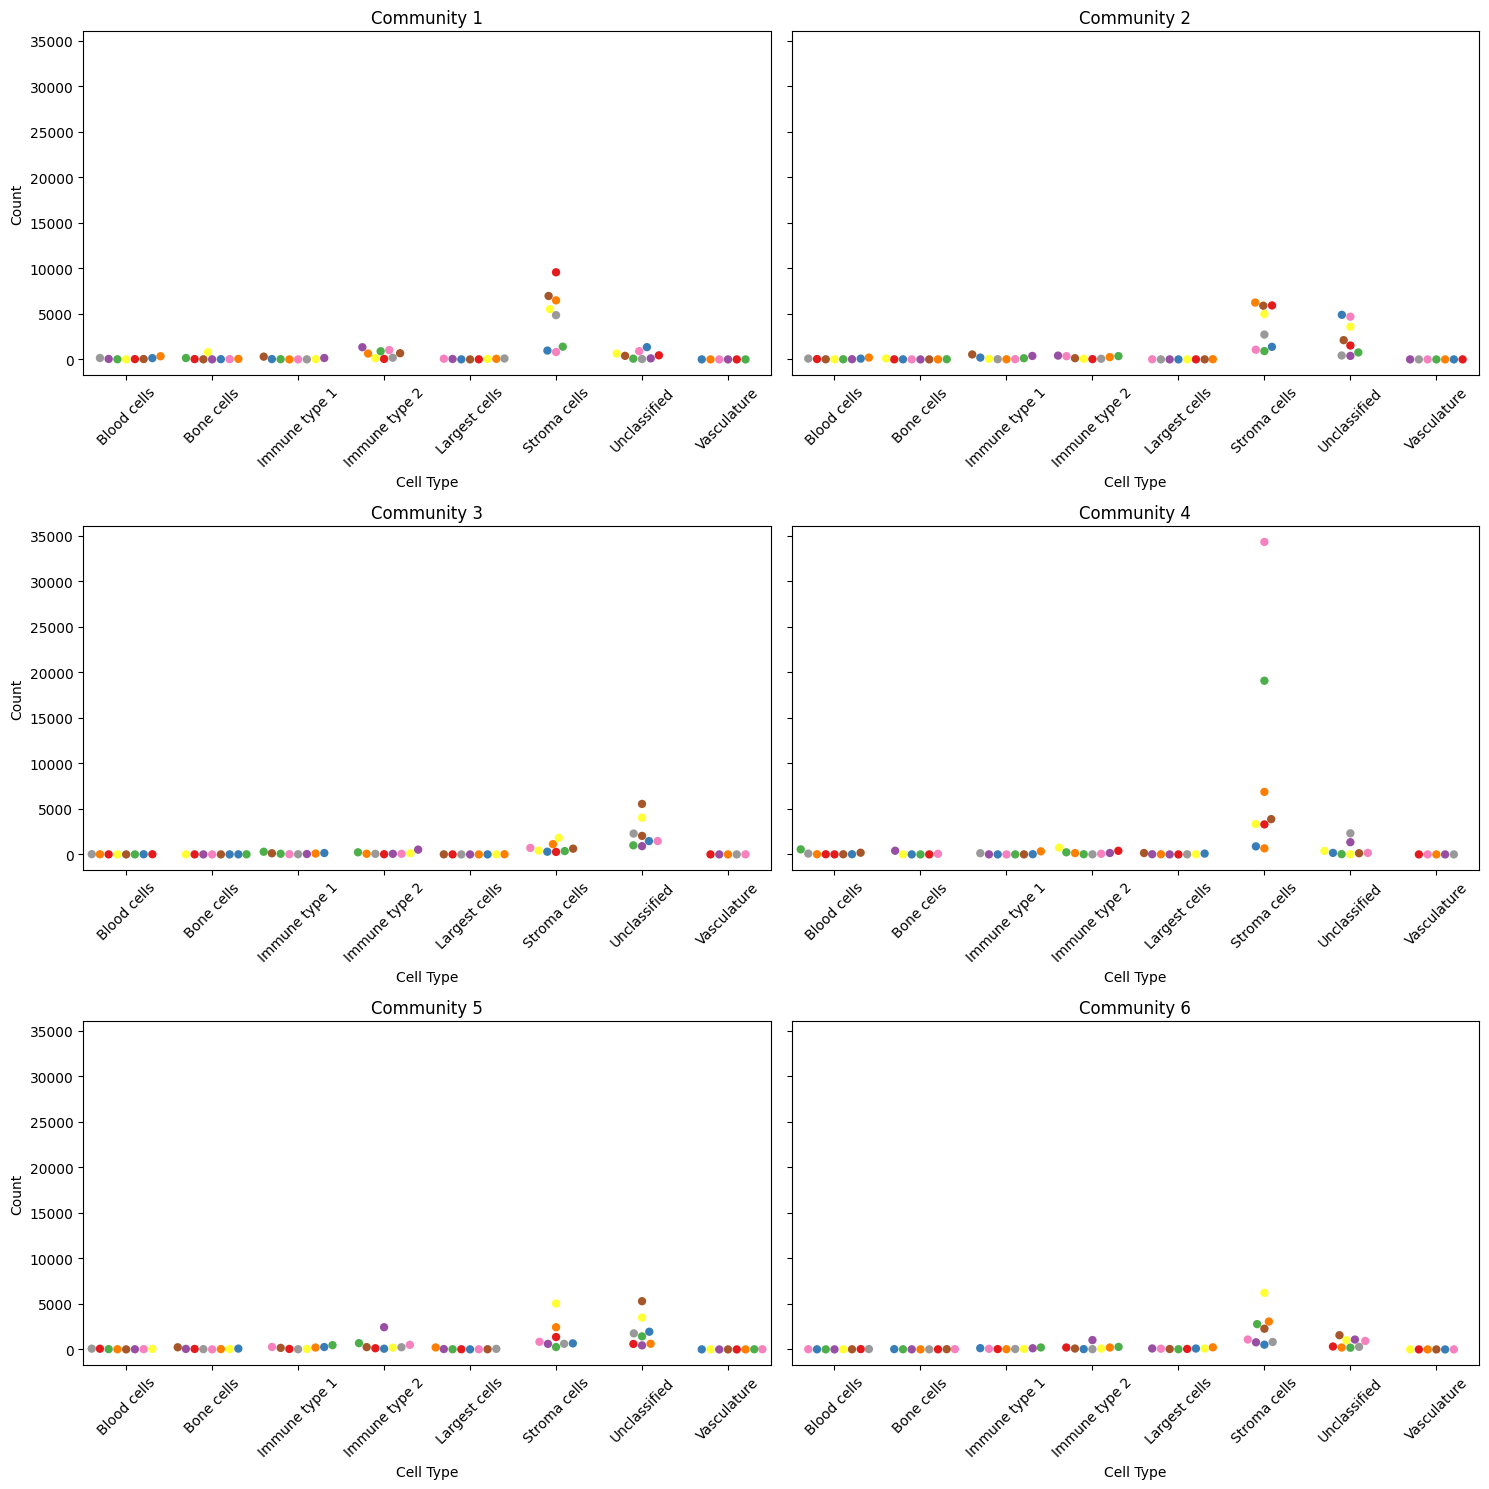

In [81]:
# Создаем swarplot, где по Ох будут типы клеток, по Оу — их количество.
# Каждый подграфик соответствует определенному типу микроокружения
# Каждый кружочек на каждом подграфике и для каждого типа клеток соответствует одному из пациентов

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharey=True)

# Итерация по категориям микроокружения и их индексам, создание swarmplot для каждой
for i, community in enumerate(interaction_communities):
    row = i // 2
    col = i % 2
    community_data = cell_counts[cell_counts['cell_interaction_community'] == community]
    ax = axes[row, col]
    sns.swarmplot(ax=ax, x='cell_type', y='count', data=community_data,
                  hue=community_data.index, palette='Set1', size=6)
    ax.set_title(f'Community {community}')
    ax.set_xlabel('Cell Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=45)
    ax.get_legend().remove()

# Настройка макета, чтобы предотвратить перекрытие элементов графика
plt.tight_layout()
plt.show()

Таким образом, по полученному графику swarplot можно сделать следующие предварительные выводы:

 - В микроокружении 1 типа в большей степени преобладают Stroma Cells, также могут присутствовать в небольшом количестве клетки Immune type 2 и Unclassified

- В микроокружении 2 типа практически одинаково присутствуют клетки Stroma Cells и Unclassified

- В микроокружении 3 типа в большей степени преобладают Unclassified, также могут присутствовать в небольшом количестве клетки Stroma Cells

- В микроокружении 4 типа в большей степени преобладают Stroma Cells, также могут присутствовать в небольшом количестве клетки Unclassified

- В микроокружении 5 типа практически одинаково присутствуют клетки Stroma Cells и Unclassified, могут встречаться также и Bone Cells

- В микроокружении 6 типа в большей степени преобладают Stroma Cells, также могут присутствовать в небольшом количестве клетки Unclassified

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_19560\473230490.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_19560\473230490.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_19560\473230490.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_19560\473230490.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes

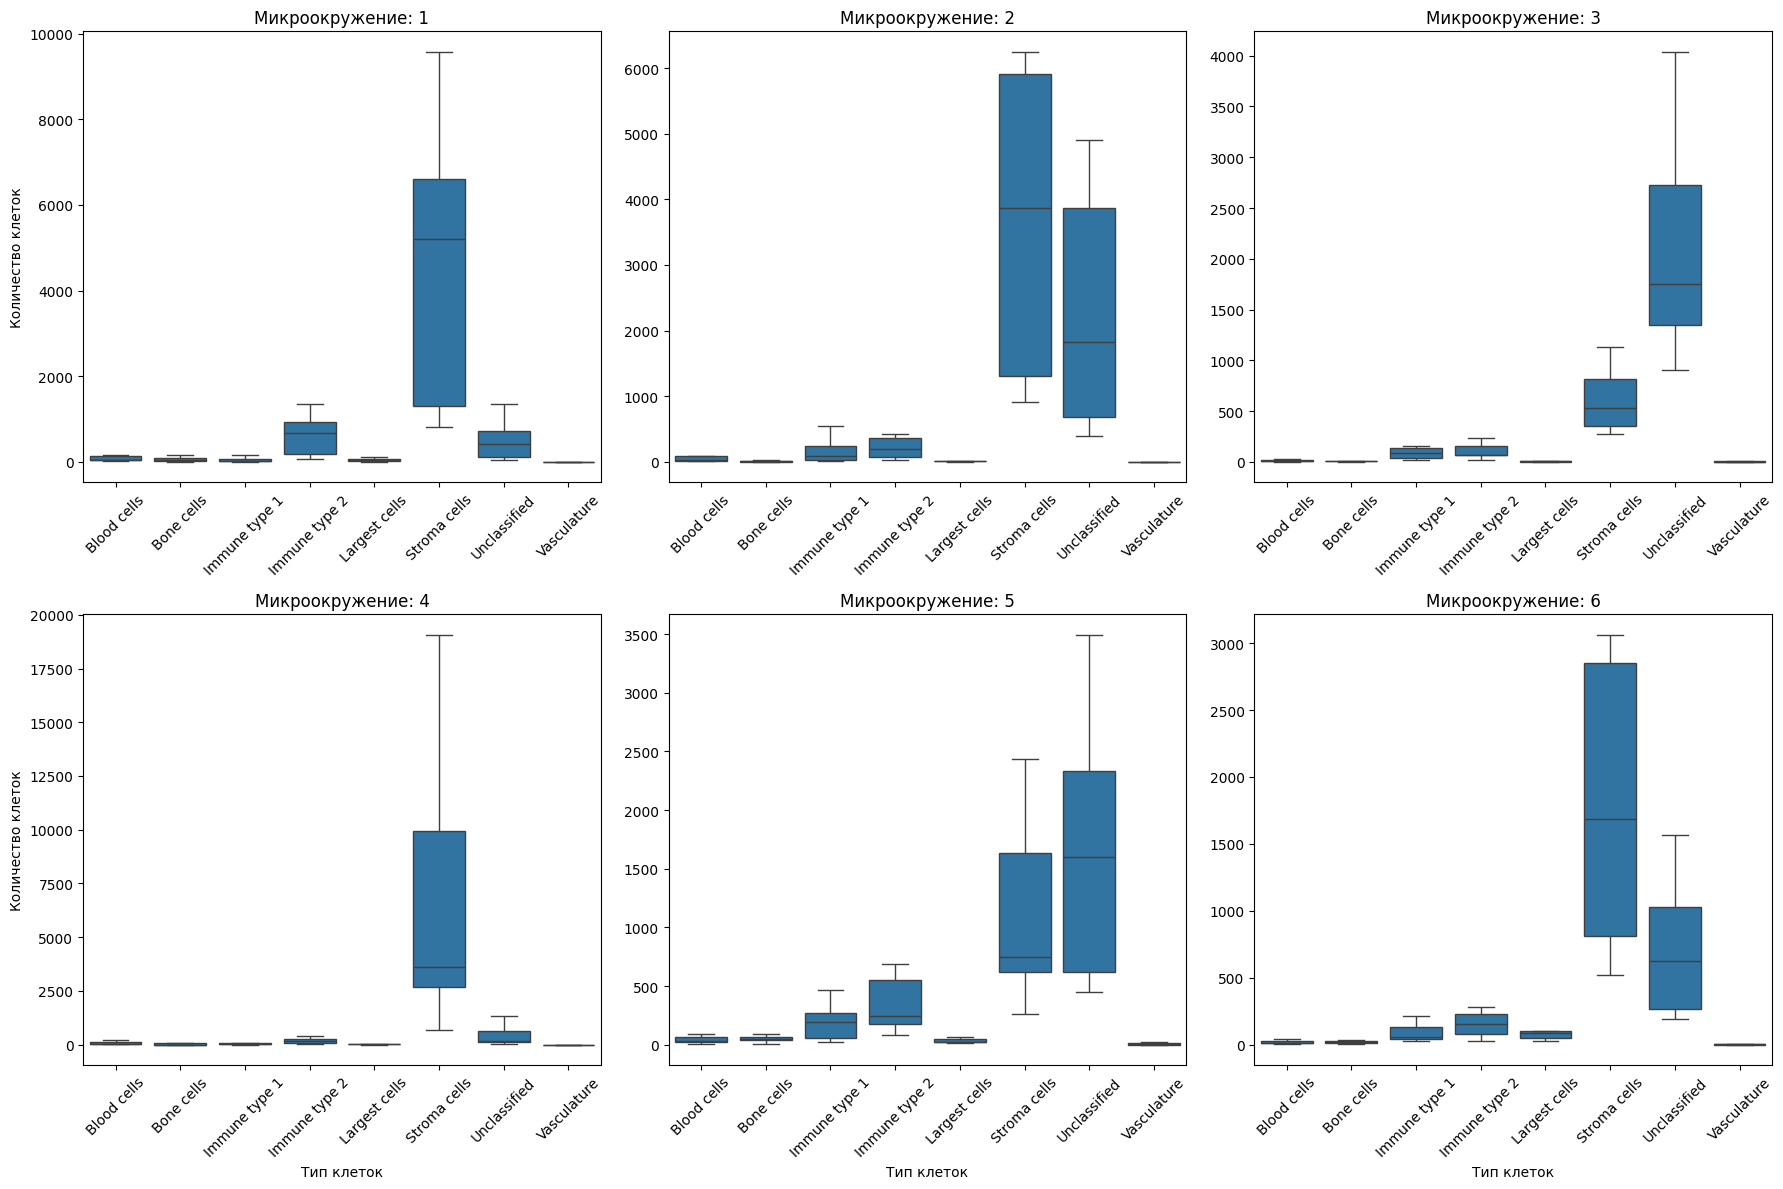

In [82]:
# Построение boxplot

communities = cell_counts['cell_interaction_community'].unique()
num_communities = len(communities)

# Создаем сетку из 6 подграфиков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, community in enumerate(communities):
    # Фильтруем данные для каждого микроокружения
    data = cell_counts[cell_counts['cell_interaction_community'] == community]

    # боксплот для каждого подграфика
    sns.boxplot(x='cell_type', y='count', data=data,
                showfliers=False, ax=axes[i])
    axes[i].set_title(f'Микроокружение: {community}')

    # Устанавливаем названия осей для первой колонки подграфиков
    if i % 3 == 0:
        axes[i].set_ylabel('Количество клеток')
    else:
        # Убираем название оси y для остальных подграфиков
        axes[i].set_ylabel('')

    # Устанавливаем названия осей для последней строки подграфиков
    if i >= num_communities - 3:
        axes[i].set_xlabel('Тип клеток')
    else:
        axes[i].set_xlabel('')

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

По графику boxblot мы видим такие же результаты, как и на swarplot, здесь также эти данные подкрепляются значениями медиан, благодаря которым мы вно видим, где медиана значимо больше или меньше. 

По многим типам клеток, значение которых значимо мало (меньше 100), мы с трудом сможем сделать вывод из-за масштаба графика. Поэтому для сравнения количества определенного типа клеток в каждом микроокружении удобнее смореть по графику боксплот с hue по типам клеток. 

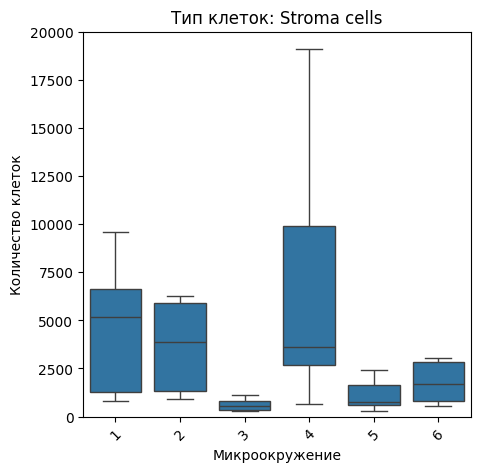

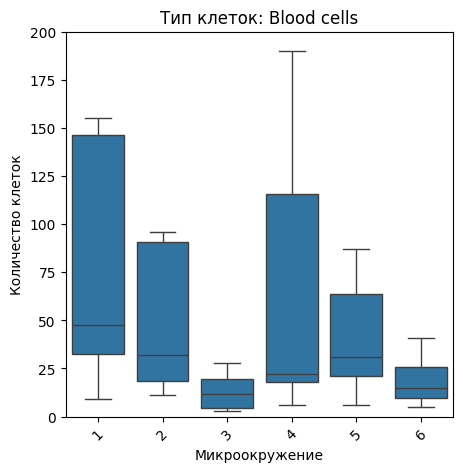

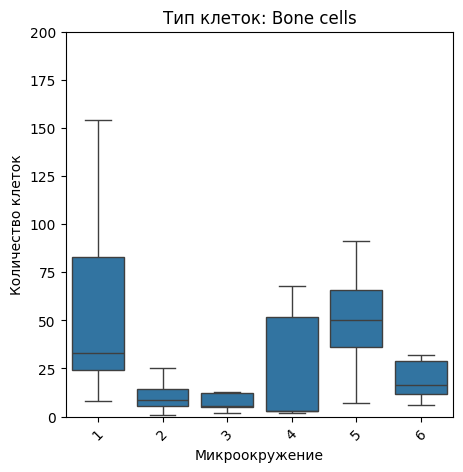

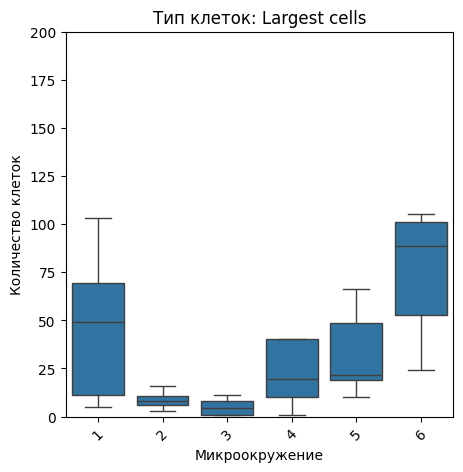

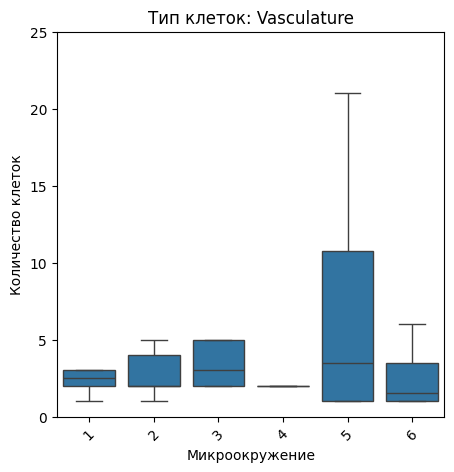

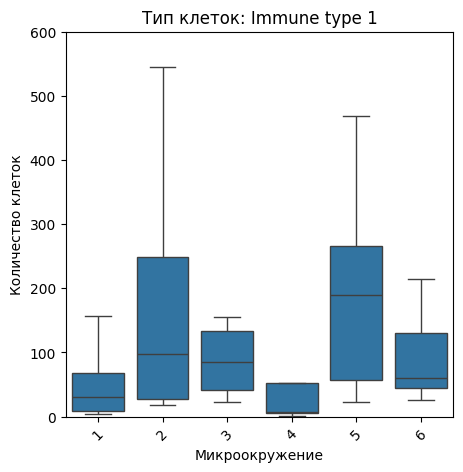

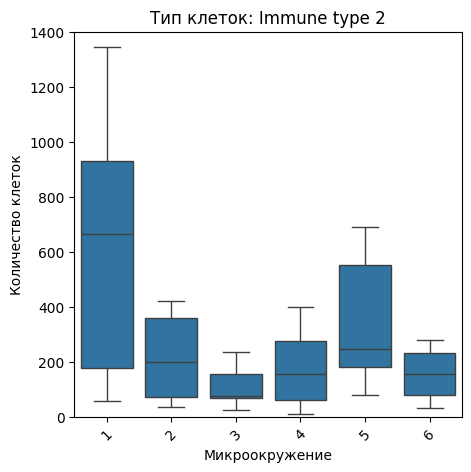

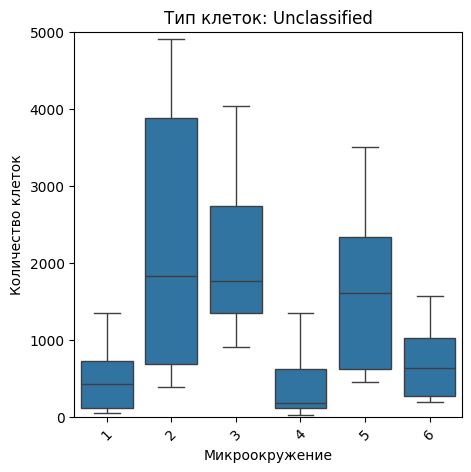

In [83]:
# Данные для различных типов клеток с их диапазонами по оси Y
cell_types_ranges = {
    'Stroma cells': 20000,
    'Blood cells': 200,
    'Bone cells': 200,
    'Largest cells': 200,
    'Vasculature': 25,
    'Immune type 1': 600,
    'Immune type 2': 1400,
    'Unclassified': 5000
}

# Создаем отдельный боксплот для каждого типа клеток
for cell_type, y_limit in cell_types_ranges.items():
    data = cell_counts[cell_counts['cell_type'] == cell_type]

    plt.figure(figsize=(5, 5))
    sns.boxplot(x='cell_interaction_community',
                y='count', data=data, showfliers=False)
    plt.title(f'Тип клеток: {cell_type}')
    plt.ylim(0, y_limit)
    plt.xticks(rotation=45)
    plt.ylabel('Количество клеток')
    plt.xlabel('Микроокружение')
    plt.show()

Таким образом, при сравнении по медианам видно, что Stroma cells и Blood cells преобладают в 1 микроокружении, при этом для Stroma cells разница в медианах достигает нескольких сотен раз, а для Blood cells десятков раз.

Bone cells преобладают в 5 микроокружении, Largest cells в 6 микроокружении, разница в медианах не превышает 2-5 раз.

Количество Vasculature оценить достаточно сложно на глаз, так как клеток сравнительно меньше, чем других типов.

Immune type 1 преобладает в 5 микроокружении, Immune type 2 в 1, а Unclassified преобладают примерно одинаково во 2, 3 и 5 микроокружениях с разницей в медианах до нескольких сотен раз.

На всех графиках мы можем заметить неравномерность и ненормальность распределения.

In [84]:
cell_counts.head()

,case_id,cell_type,cell_interaction_community,count
0,40,Blood cells,1,37
1,40,Blood cells,2,40
2,40,Blood cells,3,20
3,40,Blood cells,4,18
4,40,Blood cells,5,77


In [85]:
# уникальные значения типов клеток и типов микроокружений
cell_types = cell_counts['cell_type'].unique()
communities = cell_counts['cell_interaction_community'].unique()

# Проверка на нормальность с помощью теста Шапиро-Уилка

In [86]:
# тест на нормальность
# Создаем функцию для определения нормальности распределния данных на основе теста Шапиро-Уилка
# Функция прининимает на вход датафрейм и значение альфа, которое по дефолту равно 0.05
# Функция возвращает список кортежей results со всеми комбинациями типов клеток и типов окружений, значением p и заключением о нормальности распределения,
# и результат двух счетчиков counter_True и counter_False, чтобы быстро можно было увидеть и сравнить, какая часть подгрупп имеет нормальное и ненормальное распределение

def shapiro_test_function_2(df, alpha=0.05):
    # результирующий список
    results = []
    # счетчики
    counter_True = 0
    counter_False = 0

    for cell_type in cell_types:
        for community in communities:
            # Получаем данные для конкретного типа клеток и микроокружения
            data = df[(df['cell_type'] == cell_type) & (
                df['cell_interaction_community'] == community)]['count']
            __, p = shapiro(data)

            # Проверяем, отвергается ли нулевая гипотеза о нормальности распределения
            # Предполагаемые гипотезы:
            # H_0 = 'Данные распределены нормально'
            # H_1 = 'Данные распределены не нормально'

            if p < alpha:
                # мы не можем принять нулевую гипотезу, принимаем альтернативную - данные распределены не нормально
                results.append((cell_type, community, round(p, 5), False))
                counter_False += 1
            else:
                # мы не можем отвергнуть нулевую гипотезу и принимаем ее  - данные распределены нормально
                results.append((cell_type, community, round(p, 5), True))
                counter_True += 1

    return results, counter_True, counter_False

In [87]:
# выполняем тест на датасете
results, counter_True, counter_False = shapiro_test_function_2(cell_counts)

if counter_False == 0:
    print('Все данные распределены нормально')
else:
    print(f'{counter_True} подгрупп имеют нормальное распределение')
    print(f'{counter_False} подгрупп имеют не нормальное распределение')

28 подгрупп имеют нормальное распределение
20 подгрупп имеют не нормальное распределение


Вывод: по результатам теста Шапиро-Уилка из всех изучаемых подгрупп имеются подгруппы с ненормальным распределением. 

# Размер выборок

In [88]:
for cell_type in cell_types:
    for community in communities:
        # Получаем данные для конкретного типа клеток и микроокружения
        data = cell_counts[(cell_counts['cell_type'] == cell_type) & (
            cell_counts['cell_interaction_community'] == community)]['count']
        print(
            f'Размер выборки микроокружение {community} тип клеток {cell_type}: {data.shape}')

Размер выборки микроокружение 1 тип клеток Blood cells: (8,)
Размер выборки микроокружение 2 тип клеток Blood cells: (8,)
Размер выборки микроокружение 3 тип клеток Blood cells: (8,)
Размер выборки микроокружение 4 тип клеток Blood cells: (8,)
Размер выборки микроокружение 5 тип клеток Blood cells: (8,)
Размер выборки микроокружение 6 тип клеток Blood cells: (8,)
Размер выборки микроокружение 1 тип клеток Bone cells: (8,)
Размер выборки микроокружение 2 тип клеток Bone cells: (8,)
Размер выборки микроокружение 3 тип клеток Bone cells: (8,)
Размер выборки микроокружение 4 тип клеток Bone cells: (6,)
Размер выборки микроокружение 5 тип клеток Bone cells: (8,)
Размер выборки микроокружение 6 тип клеток Bone cells: (8,)
Размер выборки микроокружение 1 тип клеток Immune type 1: (8,)
Размер выборки микроокружение 2 тип клеток Immune type 1: (8,)
Размер выборки микроокружение 3 тип клеток Immune type 1: (8,)
Размер выборки микроокружение 4 тип клеток Immune type 1: (8,)
Размер выборки микроок

# Вывод

Таким образом, в наших выборках:

 - распределение данных в более чем половине выборок ненормально по результатам теста Шапиро-Уилка. Одна из переменных является числовой (количество клеток), другая категориальной (тип клеток cell_type). 

 - Объем выборки достаточно небольшой (всего 8 пациентов, однако, не по всем пациентам есть полноценная информация).

 - Выборки являются независимыми, так как подсчет клеток в каждом микроокружении велся раздельно, поэтому клетки не пересекаются между микроокружениями. 


### Таким образом, можно выбрать непараметрический [тест Краскела-Уоллиса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

Критерий Краскела-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех или более независимых групп, он является непараметрическим эквивалентом однофакторного дисперсионного анализа и обычно используется, когда нарушается предположение о нормальности. Критерий Краскела-Уоллиса гораздо менее чувствителен к выбросам, чем однофакторный дисперсионный анализ.

Для проведения этого теста необходимы следующие условия: 

1. Порядковая или непрерывная переменная - она у нас есть, это количество клеток

2. Независимость – наблюдения в каждой группе должны быть независимыми друг от друга - также соблюдается, так как мы будем сравнить подгруппы по типу клеток и типу микроокружения, которые не пересекаются.

3. Распределения имеют сходную форму — распределения в каждой группе должны иметь одинаковую форму. По графикам боксплот можно сказать, что распрделение неравномерное.

# Тест Краскела-Уоллиса

In [89]:
# тест Краскела-Уоллиса
# Создаем функцию для определения статистически значимой разницы для каждого типа клеток, сравнивая количество клеток в разных микроокружениях
# Функция прининимает на вход датафрейм и значение альфа, которое по дефолту равно 0.05
# Функция возвращает список кортежей results со всеми комбинациями типов клеток и типов окружений, значением p

def kruskal_function_2(df, alpha=0.05):
    # результирующий список
    results = []
    # Гипотезы для теста
    # H_0 = 'Статистически значимой разницы между группами нет'
    # H_1 = 'Статистически значимая разница между группами есть'

    for cell_type in cell_types:
        data_for_test = [df[(df['cell_type'] == cell_type) & (
            df['cell_interaction_community'] == community)]['count'].values for community in communities]
        __, p = kruskal(*data_for_test)

        # Если есть статистически значимые различия
        if p < alpha:
            # Вычисляется медианное значение количества клеток для каждого микроокружения внутри текущего типа клеток
            # Находится индекс микроокружения с максимальной медианой
            max_count_idx = np.argmax([np.median(data)
                                      for data in data_for_test])
            # По этому индексу определяется микроокружение с максимальной медианой количества клеток для текущего типа клеток
            max_community = communities[max_count_idx]
            # В результирующий список добавляется кортеж, содержащий тип клеток, микроокружение с наибольшим медианным количеством клеток и значение p
            results.append((cell_type, max_community, round(p, 5)))

    return results

Вопрос задания: В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? 

In [90]:
# результат теста и ответ на вопрос
results = kruskal_function_2(cell_counts)

for cell_type, community, p in results:
    print(
        f'Клеток {cell_type} статистически значимо больше в микроокружении {community} (p-value={p}).')

Клеток Blood cells статистически значимо больше в микроокружении 1 (p-value=0.01839).
Клеток Bone cells статистически значимо больше в микроокружении 5 (p-value=0.00451).
Клеток Largest cells статистически значимо больше в микроокружении 6 (p-value=0.00024).
Клеток Stroma cells статистически значимо больше в микроокружении 1 (p-value=0.00216).
Клеток Unclassified статистически значимо больше в микроокружении 2 (p-value=0.00195).


Таким образом, по результатам теста мы получили подтверждения нашим предположениям, сделанным по графикам, в частности боксплот.

С точки зрения прикладного клинического значения полученные результаты помогут нам охарактеризовать состав того или иного микроокружения. Например, что в микрокоружении 1 преобладают клетки Blood cells и Stroma cells, во 2 - Unclassified, в 5 - Bone cells, в 6 - Largest cells. Для дальнейшего анализа хорошо бы иметь данные о стадии заболевания и места, откуда взяты эти клетки (первичный очаг опухоли, метастазы), а также, конечно, данные диагнозе и проведенном лечении, так как все эти факторы могут иметь роль на клеточный состав опухоли. Также было бы интересно в дальнейшем проверить гипотезу о преобладании экспрессии того или иного иммунного маркера в каждом конкретном микроокружении. Знания о клеточном составе микроокружения и его свойствах крайне необходимо при моделировании клеточных процессов in vitro и in vivo.

Ограничения теста Краскела-Уоллиса (кратко, так как уже были описаны в задании 1а)

 * Нечувствительность к распределению. По нашим графикам мы видели, что распрделение достаточно негомогенно, есть значимые различия по дисперсиям и медианам, превышающее сотни раз. Поэтому, возможно, стоит поискать какой-либо другой стат тест.

 * Игнорирование величины различий: здесь, как уже было сказана, наша выборка имеет значимые различия по величине, в связи с чем, тест Краскела-Уоллиса мог оказаться и недостоверным.

 * Влияние выбросов: перед данным тестом мы не делали поиск и удаление выбросов, что могло повлиять на распределение данных и получения ненормального и негомогенного распределения во всех выборках. 

 * Отсутствие информации о парных сравнениях. Сам по себе тест Краскела-Уоллиса не дает полной информации о попарных различиях внутри выборки, однако, в нашу функцию для этого теста мы добавили такую возможность:

 - при получении статитсически значимой разницы на основе значения p-value, мы искали в этой выборке тип клеток с максимальной медианой и считали, что этот тип клеток значимо преобладает. Однако, по нашим графикам боксплот мы видим, что в каждом микроокружении может значимо преобладать по 2-3 типа клеток. В общем для дальнейшего анализа нам нужно будет выбрать тест и сравнить отдельно каждый тип клеток в каждом микроокружении попарно для получения более точных результатов.

В качестве возможных улучшений для проведения теста, можно рассмотреть проведение пост-хок анализа с поправкой на множественные сравнения (например, метод Данна) для определения пар групп с различиями.

Для оценки значимости и величины эффектов теста Краскела-Уоллиса можно также провести оценку (кратко):

1. Эффектного размера 

2. с помощью пост-хок тестов (описано выше)

3. доверительных интервалов для медиан или средних рангов каждой группы

4. с помощью визуализации данных - в нашем анализе мы это проводили с помощью анализа графиков swarplot и двух видов boxplot.

5. средних рангов, которые использовались в тесте Краскела-Уоллиса

6. с помощью создания графиков кумулятивной вероятности для каждой группы может помочь понять распределение данных и различия между группами.

При проведении множественных статистических тестов необходимо провдить корректировку уровня значимости для контроля над ошибками I типа, связанными с множественными сравнениями. Использование поправки Бонферрони или других методов коррекции может помочь уменьшить вероятность ложноположительных результатов. 

В нашем случае мы улучшили тест Краскела-Уоллиса за счет поиска максимальной медианы в той выборке, где была получена статистически значимая разница. 

# Задание 3

Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

 - по Ох будут микроокружения,
 - по Оу — их доля в ткани пациента.

Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

*Доля микроокружения рассчитывается следующим образом: надо вычислить общее количество клеток для каждого пациента и на основе этого рассчитывают долю каждого микроокружения в общем количестве клеток*

In [91]:
# Рассчитываем общее количество клеток для каждого пациента
total_cells_per_patient = df_2.groupby(
    'case_id')['cell_type'].count().reset_index()
total_cells_per_patient.rename(
    columns={'cell_type': 'total_cells'}, inplace=True)

# Рассчитываем общее количество клеток в каждом микроокружении для каждого пациента
cells_per_community_per_patient = df_2.groupby(
    ['case_id', 'cell_interaction_community'])['cell_type'].count().reset_index()
cells_per_community_per_patient.rename(
    columns={'cell_type': 'cells_per_community'}, inplace=True)

In [92]:
# Объединение датасетов
combined_data = pd.merge(cells_per_community_per_patient,
                         total_cells_per_patient, on='case_id')
combined_data.head()

,case_id,cell_interaction_community,cells_per_community,total_cells
0,40,1,7421,50062
1,40,2,7734,50062
2,40,3,8252,50062
3,40,4,3669,50062
4,40,5,13664,50062


In [93]:
# Добавляем столбец "age_group"
age = df_2[['case_id', 'age_group']].drop_duplicates()
combined_data = pd.merge(combined_data, age, on='case_id')
combined_data.sample(5)

,case_id,cell_interaction_community,cells_per_community,total_cells,age_group
21,566,4,3584,13732,0
18,566,1,1287,13732,0
37,891,2,1619,8825,0
36,891,1,1044,8825,0
41,891,6,1561,8825,0


In [94]:
# Расчет доли для каждого микроокружения у каждого пациента
combined_data['proportion'] = combined_data['cells_per_community'] / \
    combined_data['total_cells']
combined_data.head()

,case_id,cell_interaction_community,cells_per_community,total_cells,age_group,proportion
0,40,1,7421,50062,0,0.148236
1,40,2,7734,50062,0,0.154488
2,40,3,8252,50062,0,0.164836
3,40,4,3669,50062,0,0.073289
4,40,5,13664,50062,0,0.272942


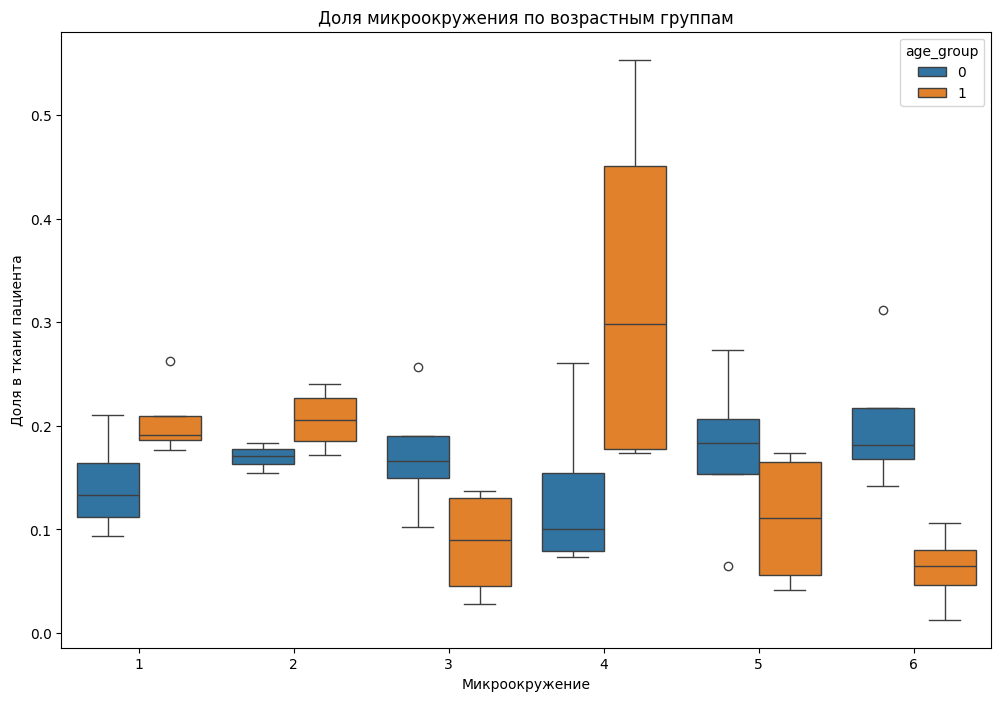

In [95]:
# Построение boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=combined_data, x='cell_interaction_community',
            y='proportion', hue='age_group')
plt.title('Доля микроокружения по возрастным группам')
plt.xlabel('Микроокружение')
plt.ylabel('Доля в ткани пациента')
plt.show()

Таким образом, по графику мы видим, что средняя доля в 1,2 и 4 типах микроокружений больше в молодой возрастной группе (группа 1), а в 3,5 и 6 типах микроокружений средняя доля выше в группе пожилых (группа 0). Проверим наши предположения с помощью статистического теста.

# Проверка на нормальность с помощью теста Шапиро-Уилка

In [96]:
# Группируем данные по микроокружению и возрастной группе
grouped_data = combined_data.groupby(
    ['cell_interaction_community', 'age_group'])

H_0 = 'Данные распределены нормально'
H_1 = 'Данные распределены не нормально'
alpha = 0.05
print(f'alpha = {alpha}')

# Применяем тест Шапиро-Уилка для каждой группы
for community in combined_data['cell_interaction_community'].unique():
    for age in combined_data['age_group'].unique():
        group = grouped_data.get_group((community, age))['proportion']
        __, p_value = shapiro(group)
        print(
            f"Микроокружение: {community}, Возрастная группа: {age}, P-значение теста Шапиро-Уилка: {p_value:.5f}")
        if p_value > alpha:
            print(H_0)
        else:
            print(f'Мы отвергаем нулевую гипотезу.{H_1}')
        print("")

alpha = 0.05
Микроокружение: 1, Возрастная группа: 0, P-значение теста Шапиро-Уилка: 0.73362
Данные распределены нормально

Микроокружение: 1, Возрастная группа: 1, P-значение теста Шапиро-Уилка: 0.07849
Данные распределены нормально

Микроокружение: 2, Возрастная группа: 0, P-значение теста Шапиро-Уилка: 0.94996
Данные распределены нормально

Микроокружение: 2, Возрастная группа: 1, P-значение теста Шапиро-Уилка: 0.78188
Данные распределены нормально

Микроокружение: 3, Возрастная группа: 0, P-значение теста Шапиро-Уилка: 0.65863
Данные распределены нормально

Микроокружение: 3, Возрастная группа: 1, P-значение теста Шапиро-Уилка: 0.26295
Данные распределены нормально

Микроокружение: 4, Возрастная группа: 0, P-значение теста Шапиро-Уилка: 0.10945
Данные распределены нормально

Микроокружение: 4, Возрастная группа: 1, P-значение теста Шапиро-Уилка: 0.26790
Данные распределены нормально

Микроокружение: 5, Возрастная группа: 0, P-значение теста Шапиро-Уилка: 0.63509
Данные распределены

# Размер выборок

In [97]:
for community in combined_data['cell_interaction_community'].unique():
    for age in combined_data['age_group'].unique():
        sample_size = combined_data[(combined_data['cell_interaction_community'] == community) &
                                    (combined_data['age_group'] == age)].shape[0]
        print(
            f'Размер выборки для микроокружения {community}, возрастной группы {age}: {sample_size}')

Размер выборки для микроокружения 1, возрастной группы 0: 4
Размер выборки для микроокружения 1, возрастной группы 1: 4
Размер выборки для микроокружения 2, возрастной группы 0: 4
Размер выборки для микроокружения 2, возрастной группы 1: 4
Размер выборки для микроокружения 3, возрастной группы 0: 4
Размер выборки для микроокружения 3, возрастной группы 1: 4
Размер выборки для микроокружения 4, возрастной группы 0: 4
Размер выборки для микроокружения 4, возрастной группы 1: 4
Размер выборки для микроокружения 5, возрастной группы 0: 4
Размер выборки для микроокружения 5, возрастной группы 1: 4
Размер выборки для микроокружения 6, возрастной группы 0: 4
Размер выборки для микроокружения 6, возрастной группы 1: 4


# Вывод

В наших выборках:

 - Одна из переменных является числовой (доля микроокружения), другая категориальной (возрастная группа). 

 - Данные по результатам теста Шапиро-Уилка распределены нормально, однако, в связи с маленьким размером выборки проверка на нормальность распределения может быть нецелесообразной.

 - Объем выборки маленький (4)

 - Выборки являются независимыми, так как подсчет клеток в каждом микроокружении велся раздельно, поэтому клетки не пересекаются между микроокружениями. 


### Таким образом, можно использовать t-критерий Стьюдента для независимых выборок (two-sample t-test)

Однако, с таким маленьким размером выборки (n=4), результаты t-теста могут быть не очень надежными, потому что нормальное распределение данных сложно достоверно оценить при таком малом количестве данных.

# t-критерий Стьюдента

In [98]:
H_0 = 'Статистической разнницы между средними значениями в двух группах нет'
H_1 = 'Есть статистически значимая разнница между средними значениями в двух группах'
alpha = 0.05
print(f'alpha = {alpha}')

for community in df_2['cell_interaction_community'].unique():
    # Деалем выборки по возрастным группам и типам микроокружения
    group1 = combined_data[(combined_data['cell_interaction_community'] == community) &
                           (combined_data['age_group'] == 1)]['proportion']

    group2 = combined_data[(combined_data['cell_interaction_community'] == community) &
                           (combined_data['age_group'] == 0)]['proportion']
    # Выполнение t-теста для независимых выборок
    __, p_value = ttest_ind(group1, group2)
    print(f"Микроокружение: {community}, p-значение: {round(p_value,3)}")
    if p_value > alpha:
        print(H_0)
    else:
        print(f'Мы отвергаем нулевую гипотезу.{H_1}')
        print("")

alpha = 0.05
Микроокружение: 1, p-значение: 0.096
Статистической разнницы между средними значениями в двух группах нет
Микроокружение: 2, p-значение: 0.074
Статистической разнницы между средними значениями в двух группах нет
Микроокружение: 3, p-значение: 0.083
Статистической разнницы между средними значениями в двух группах нет
Микроокружение: 4, p-значение: 0.104
Статистической разнницы между средними значениями в двух группах нет
Микроокружение: 5, p-значение: 0.267
Статистической разнницы между средними значениями в двух группах нет
Микроокружение: 6, p-значение: 0.014
Мы отвергаем нулевую гипотезу.Есть статистически значимая разнница между средними значениями в двух группах



Таким образом, по результатам t-test мы получили, что статистически значимая разница между средними значениями долей микроокружения в возрастных группах есть только для микроокружения 6 типа, то есть сопоставляя результаты теста с графиком боксплот мы можем сказать следующее:

 - Средняя доля 6 типа микроокружения выше в группе пожилых (группа 0). 
 
В остальных группах разница в средних долях микроокружений между возрастными группами незначимая. 

Главным нашим недостатком в данном случае является очень маленький набор данных, в связи с чем есть вероятность получения недостоверных данных по результатам t-test. Чтобы увеличить объем выборки для проведения статистического теста, можно использовать несколько подходов:

 - Накопление данных: продолжение проведения сбора данных или поиск в открытых базах для пооплнения нашей выборки.

 - Ресемплинг: здесь можно попробовать использовать бутстрэпинг, чтобы искусственно увеличить размер выборки путем создания повторных выборок с заменой из исходных данных.


Ограничения t-критерия Стьюдента для независимых выборок:

 - Нормальное распределение: t-критерий наиболее точен, когда данные имеют нормальное распределение. Для небольших выборок отклонения от нормальности могут сильно повлиять на результаты, что очень вероятно в нашем случае.

 - Однородность дисперсий: предполагается, что дисперсии двух выборок равны. Если дисперсии существенно различаются, классический t-тест может давать искаженные результаты.

 - Независимость выборок : данные должны быть независимыми, то есть результаты одной выборки не должны влиять на результаты другой.

Возможности улучшения:

 - Использование Welch t-теста: Если предположение о равенстве дисперсий нарушено, можно использовать t-тест Уэлча, который не делает предположений о равенстве дисперсий.
 - Bootstrap методы: (описано выше)
 - Увеличение размера выборки (описано выше)
 - Непараметрические аналоги: если данные сильно отклоняются от предположений t-теста, можно использовать непараметрические тесты, такие как Манна-Уитни, которые не делают строгих предположений о распределении данных.

Попробуем выполнить непараметрически тест Манна-Уитни с поправкой Бонферрони:

In [99]:

alpha = 0.05
communities = df_2['cell_interaction_community'].unique()
num_tests = len(communities)
bonferroni_alpha = alpha / num_tests

print(f'Исходный alpha = {alpha}')
print(f'Bonferroni alpha = {bonferroni_alpha}')

for community in communities:
    # Делаем выборки по возрастным группам и типам микроокружения
    group1 = combined_data[(combined_data['cell_interaction_community'] == community) &
                           (combined_data['age_group'] == 1)]['proportion']
    group2 = combined_data[(combined_data['cell_interaction_community'] == community) &
                           (combined_data['age_group'] == 0)]['proportion']
    # Выполнение U-теста Манна-Уитни для независимых выборок
    __, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"Микроокружение: {community}, p-значение: {round(p_value, 3)}")
    if p_value > bonferroni_alpha:
        print('H_0: Статистической разницы между средними значениями в двух группах нет')
    else:
        print('H_1: Есть статистически значимая разница между средними значениями в двух группах')
        print("")

Исходный alpha = 0.05
Bonferroni alpha = 0.008333333333333333
Микроокружение: 1, p-значение: 0.2
H_0: Статистической разницы между средними значениями в двух группах нет
Микроокружение: 2, p-значение: 0.114
H_0: Статистической разницы между средними значениями в двух группах нет
Микроокружение: 3, p-значение: 0.114
H_0: Статистической разницы между средними значениями в двух группах нет
Микроокружение: 4, p-значение: 0.114
H_0: Статистической разницы между средними значениями в двух группах нет
Микроокружение: 5, p-значение: 0.114
H_0: Статистической разницы между средними значениями в двух группах нет
Микроокружение: 6, p-значение: 0.029
H_0: Статистической разницы между средними значениями в двух группах нет


Таким образом, по результатам теста Манна-Уитни с поправкой Бонферрони мы получили, что статитсически значимых различий между выбрками молодых и пожилых пациентов нет. Однако, по значениям p-value мы видим, что без учета поправки статистически значимая разница есть в 6 микроокружении. И так как аналогичные результаты мы получили и в предыдущем тесте, будем считать, что разница действительно есть в 6 микроркужении между молодыми и пожилыми пациентами. Но накопление и увеличение данных здесь крайне необходимо.

## Задание 4

Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов?

Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

In [100]:
# делаем две выборки по нужным столбцам по возрастным группам
# Список типов клеток для фильтрации
cell_types = ['Stroma cells', 'Immune type 1', 'Immune type 2']

# выборка млодых пациентов
young = df_2[(df_2['age_group'] == 1) & (df_2['cell_type'].isin(cell_types))][
    ['case_id', 'distance_to_vasculature', 'distance_to_largest_cell', 'cell_type']].reset_index(drop=True)

# выборка пожилых пациентов
old = df_2[(df_2['age_group'] == 0) & (df_2['cell_type'].isin(cell_types))][
    ['case_id', 'distance_to_vasculature', 'distance_to_largest_cell', 'cell_type']].reset_index(drop=True)

young.head()

,case_id,distance_to_vasculature,distance_to_largest_cell,cell_type
0,199,634.200203,983.403426,Stroma cells
1,199,610.444296,1000.488024,Immune type 2
2,199,782.995484,787.660055,Stroma cells
3,199,811.000834,608.351406,Stroma cells
4,199,704.830780,883.960378,Immune type 1


In [101]:
# Расчет средних расстояний до ближайших сосудов и крупнейших клеток для обеих возрастных групп
mean_young = young.groupby('cell_type')[
    ['distance_to_vasculature', 'distance_to_largest_cell']].mean()
mean_young = mean_young.rename(columns={'distance_to_vasculature': 'mean_distance_to_vasculature',
                               'distance_to_largest_cell': 'mean_distance_to_largest_cell'})

mean_old = old.groupby('cell_type')[
    ['distance_to_vasculature', 'distance_to_largest_cell']].mean()
mean_old = mean_old.rename(columns={'distance_to_vasculature': 'mean_distance_to_vasculature',
                           'distance_to_largest_cell': 'mean_distance_to_largest_cell'})

mean_old

,mean_distance_to_vasculature,mean_distance_to_largest_cell
cell_type,,
Immune type 1,817.844810,760.573066
Immune type 2,800.213120,736.503375
Stroma cells,830.807948,760.470815


In [102]:
# Формироваине наблюдений для каждой возрастной группы по разницам расстояний
young_1 = mean_young.loc['Immune type 1', 'mean_distance_to_vasculature'] - \
    mean_young.loc['Stroma cells', 'mean_distance_to_vasculature']
young_2 = mean_young.loc['Immune type 2', 'mean_distance_to_vasculature'] - \
    mean_young.loc['Stroma cells', 'mean_distance_to_vasculature']
young_3 = mean_young.loc['Immune type 1', 'mean_distance_to_largest_cell'] - \
    mean_young.loc['Stroma cells', 'mean_distance_to_largest_cell']
young_4 = mean_young.loc['Immune type 2', 'mean_distance_to_largest_cell'] - \
    mean_young.loc['Stroma cells', 'mean_distance_to_largest_cell']

old_1 = mean_old.loc['Immune type 1', 'mean_distance_to_vasculature'] - \
    mean_old.loc['Stroma cells', 'mean_distance_to_vasculature']
old_2 = mean_old.loc['Immune type 2', 'mean_distance_to_vasculature'] - \
    mean_old.loc['Stroma cells', 'mean_distance_to_vasculature']
old_3 = mean_old.loc['Immune type 1', 'mean_distance_to_largest_cell'] - \
    mean_old.loc['Stroma cells', 'mean_distance_to_largest_cell']
old_4 = mean_old.loc['Immune type 2', 'mean_distance_to_largest_cell'] - \
    mean_old.loc['Stroma cells', 'mean_distance_to_largest_cell']

young_list = [young_1, young_2, young_3, young_4]
old_list = [old_1, old_2, old_3, old_4]

In [103]:
young_list

[-0.6156435253022892,
 -35.52878599869928,
 -12.749970679090097,
 -4.239079624805981]

In [104]:
# Расчет средних значений всей оригинальной выборки
# делаем выборку по нужным столбцам и интересующим типам клеток для дальнейшего поиска средних значений в оригинальной выборке

df_3 = df_2[(df_2['cell_type'].isin(cell_types))][
    ['case_id', 'age_group', 'distance_to_vasculature', 'distance_to_largest_cell', 'cell_type']].reset_index(drop=True).reset_index(drop=True)

mean_original = df_3.groupby('cell_type')[
    ['distance_to_vasculature', 'distance_to_largest_cell']].mean()
mean_original = mean_original.rename(columns={
                                     'distance_to_vasculature': 'mean_distance_to_vasculature', 'distance_to_largest_cell': 'mean_distance_to_largest_cell'})

# Формироваине наблюдений для каждой возрастной группы по разницам расстояний
original_1 = mean_original.loc['Immune type 1', 'mean_distance_to_vasculature'] - \
    mean_original.loc['Stroma cells', 'mean_distance_to_vasculature']
original_2 = mean_original.loc['Immune type 2', 'mean_distance_to_vasculature'] - \
    mean_original.loc['Stroma cells', 'mean_distance_to_vasculature']
original_3 = mean_original.loc['Immune type 1', 'mean_distance_to_largest_cell'] - \
    mean_original.loc['Stroma cells', 'mean_distance_to_largest_cell']
original_4 = mean_original.loc['Immune type 2', 'mean_distance_to_largest_cell'] - \
    mean_original.loc['Stroma cells', 'mean_distance_to_largest_cell']

original_list = [original_1, original_2, original_3, original_4]

# Booststrap-генерация наблюдений

In [105]:
# Создание бутстрап-выборок с помощью функции, которая принимает на вход исходную выборку и количество бутстрап-выборок (по дефолту - 10000)

def bootstrap_function(data, n_bootstrap=10000):
    bootstrap_samples = [np.random.choice(data, size=len(
        data), replace=True) for n in range(n_bootstrap)]

    # Вычисление статистики интереса (среднего) для каждой бутстрап-выборки
    bootstrap_means = [np.mean(sample) for sample in bootstrap_samples]

    # Оценка среднего значения и 95% доверительного интервала
    mean_estimate = np.mean(data)
    confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

    print(f"Оценка среднего: {mean_estimate:.2f}")
    print(
        f"95% доверительный интервал: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]")

In [106]:
bootstrap_function(young_list)

Оценка среднего: -13.28
95% доверительный интервал: [-27.71, -2.43]


In [107]:
bootstrap_function(old_list)

Оценка среднего: -16.86
95% доверительный интервал: [-27.28, -5.92]


Доверительные интервалы двух выборок по возрасту пересекаются, что может свидетельствовать о том, что различие не является статистически значимым на заданном уровне значимости.

Получившиеся доверительные интервалы достаточно велики, поэтому для получения более точных результатов можно в дальнейшем разделить по типам клеток (для Immune type 1 и Immune type 2) и дистанциям (mean_distance_to_vasculature и mean_distance_to_largest_cell)

In [108]:
bootstrap_function(original_list)

Оценка среднего: -23.55
95% доверительный интервал: [-49.48, -8.13]


Доверительные интервалы оригинальной выборки получились еще шире. И так как доверительные интервалы обеих выборок входят и пересекаются с доверительными интервалами оригинальной выборки, а среднее значение оригинальной выборки входит в дверительные интервалы двух выборок по возрасту, то можно сказать, что статистически значимая разница отсутствует. 

Как и было сказано выше, для получения более достоверных и точных значений необходимо в дальнейшем разделять выборки по типам клеток и по типам дистанций, что даст, возможно, более корректный результат для каждой подвыборки. Наши получившиеся результаты по сути очень обобщенные, так как разделены всего лишь по принципу возраста. 

# Расчет корреляции признаков

In [109]:
young.head()

,case_id,distance_to_vasculature,distance_to_largest_cell,cell_type
0,199,634.200203,983.403426,Stroma cells
1,199,610.444296,1000.488024,Immune type 2
2,199,782.995484,787.660055,Stroma cells
3,199,811.000834,608.351406,Stroma cells
4,199,704.830780,883.960378,Immune type 1


In [110]:
# Проверка нормальности распределения
shapiro_test_function(young, 'distance_to_vasculature')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [111]:
shapiro_test_function(young, 'distance_to_largest_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



In [112]:
shapiro_test_function(old, 'distance_to_vasculature')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



In [113]:
shapiro_test_function(old, 'distance_to_largest_cell')

alpha = 0.05
Тест на нормальное распределние типа клеток: Stroma cells
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 2
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально

Тест на нормальное распределние типа клеток: Immune type 1
p=0.000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально



Все данные распределены ненормально. Выбираем корреляцию Спирмена

In [114]:
# Кодирование типов клеток в числовые значения
young['cell_type_encoded'] = young['cell_type'].replace({
    'Immune type 1': 1,
    'Immune type 2': 1,
    'Stroma cells': 0
})

old['cell_type_encoded'] = old['cell_type'].replace({
    'Immune type 1': 1,
    'Immune type 2': 1,
    'Stroma cells': 0
})

# Корреляционный анализ для молодых для признака расстояние до ближайших крупных клеток
correlation_young, p_value_young = spearmanr(
    young['cell_type_encoded'], young['distance_to_largest_cell'])

# Корреляционный анализ для пожилых для признака расстояние до ближайших крупных клеток
correlation_old, p_value_old = spearmanr(
    old['cell_type_encoded'], old['distance_to_largest_cell'])

print(
    f'Корреляция для молодых: {round(correlation_young,3)}, p-значение: {round(p_value_young,5)}')
print(
    f'Корреляция для пожилых: {round(correlation_old,3)}, p-значение: {round(p_value_old,5)}')

Корреляция для молодых: -0.019, p-значение: 0.0
Корреляция для пожилых: -0.038, p-значение: 0.0


In [115]:
# Корреляционный анализ для молодых для признака расстояние до ближайших сосудов
correlation_young, p_value_young = spearmanr(
    young['cell_type_encoded'], young['distance_to_vasculature'])

# Корреляционный анализ для пожилых для признака расстояние до ближайших сосудов
correlation_old, p_value_old = spearmanr(
    old['cell_type_encoded'], old['distance_to_vasculature'])

print(
    f'Корреляция для молодых: {round(correlation_young,3)}, p-значение: {round(p_value_young,5)}')
print(
    f'Корреляция для пожилых: {round(correlation_old,3)}, p-значение: {round(p_value_old,5)}')

Корреляция для молодых: -0.032, p-значение: 0.0
Корреляция для пожилых: -0.056, p-значение: 0.0


Значения коэффициента корреляции Спирмена лежат в диапазоне от -1 до +1.

 - +1 означает идеальную положительную монотонную связь: когда значение одной переменной увеличивается, значение другой переменной также увеличивается.
 - -1 означает идеальную отрицательную монотонную связь: когда значение одной переменной увеличивается, значение другой переменной уменьшается.
0 означает отсутствие монотонной связи между переменными.

Следовательно, между признаками в нашем случае связь очень слабоотрицательная, либо вообще отсутствует. 

Но при этом p-значение во всех случаях меньше заданного уровня значимости (alpha = 0.05), то корреляция статистически значима, то есть вероятность получить такое или более экстремальное значение коэффициента корреляции при условии, что между переменными нет связи (нулевая гипотеза), мала.

# Задание 5

Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов?

Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

In [116]:
# делаем две выборки по нужным столбцам по возрастным группам и типам иммунных клеток

# выборка млодых пациентов
young_immune_1 = df_2[(df_2['age_group'] == 1) & (df_2['cell_type'] == 'Immune type 1')][
    ['case_id', 'distance_to_vasculature']].reset_index(drop=True)
young_immune_2 = df_2[(df_2['age_group'] == 1) & (df_2['cell_type'] == 'Immune type 2')][
    ['case_id', 'distance_to_vasculature']].reset_index(drop=True)

# выборка пожилых пациентов
old_immune_1 = df_2[(df_2['age_group'] == 0) & (df_2['cell_type'] == 'Immune type 1')][
    ['case_id', 'distance_to_vasculature']].reset_index(drop=True)
old_immune_2 = df_2[(df_2['age_group'] == 0) & (df_2['cell_type'] == 'Immune type 2')][
    ['case_id', 'distance_to_vasculature']].reset_index(drop=True)

young_immune_1.head()

,case_id,distance_to_vasculature
0,199,704.830780
1,199,930.563167
2,199,1203.410427
3,199,1269.298194
4,199,1099.300967


In [117]:
# вычисление средних значений для каждого пациента в каждой выборке
young_immune_1 = young_immune_1.groupby(
    'case_id')['distance_to_vasculature'].mean().reset_index()
young_immune_2 = young_immune_2.groupby(
    'case_id')['distance_to_vasculature'].mean().reset_index()
old_immune_1 = old_immune_1.groupby(
    'case_id')['distance_to_vasculature'].mean().reset_index()
old_immune_2 = old_immune_2.groupby(
    'case_id')['distance_to_vasculature'].mean().reset_index()

young_immune_1.head()

,case_id,distance_to_vasculature
0,199,1015.312101
1,693,1037.405389
2,708,792.446183
3,983,927.923608


In [118]:
# подготовка данных к нужному формату для проведения теста

young_immune_1_list = young_immune_1['distance_to_vasculature'].unique(
).tolist()
young_immune_2_list = young_immune_2['distance_to_vasculature'].unique(
).tolist()
old_immune_1_list = old_immune_1['distance_to_vasculature'].unique().tolist()
old_immune_2_list = old_immune_2['distance_to_vasculature'].unique().tolist()

# Пермутационный тест

In [119]:
# Функция для проведения пермутационного теста на 2 выборках
# Принимает на вход два списка, проводит тест и печатает результат наблюдаемой статистики и Достигнутого уровеня значимости (p-value)

def permutation_function(df1, df2):

    # Объединенные данные
    combined_data = df1 + df2

    # Наблюдаемая статистика (разница средних)
    observed_stat = np.mean(df1) - np.mean(df2)

    # Количество перемешиваний
    n_permutations = 10000

    # Проведение пермутационного теста
    permutationstats = []

    for n in range(n_permutations):

        # Перемешивание наблюдений
        np.random.shuffle(combined_data)
        permuted_group1 = combined_data[:len(df1)]
        permuted_group2 = combined_data[len(df2):]

        # Вычисление статистики для перемешанных групп
        permutation_stat = np.mean(permuted_group1) - np.mean(permuted_group2)
        permutationstats.append(permutation_stat)

    # Вычисление достигнутого уровня значимости (p-value)
    p_value = np.mean(np.abs(permutationstats) >= np.abs(observed_stat))

    print(f"Наблюдаемая статистика: {observed_stat:.2f}")
    print(f"Достигнутый уровень значимости (p-value): {p_value:.4f}")

In [120]:
permutation_function(young_immune_1_list, old_immune_1_list)

Наблюдаемая статистика: 111.57
Достигнутый уровень значимости (p-value): 0.2000


In [121]:
permutation_function(young_immune_2_list, old_immune_2_list)

Наблюдаемая статистика: 127.66
Достигнутый уровень значимости (p-value): 0.1355


Таким образом, мы получили следующие значения при сравнении двух выборок по возрастам и по типам иммунных клеток:

 - Иммунные клетки 1 типа, сравнение пожилой и молодой выборки: p-value = 0.2055

 - Иммунные клетки 2 типа, сравнение пожилой и молодой выборки: p-value = 0.1359

При значении alpha = 0.05 и следующими гипотезами:

 - Н0 - статистически значимых различий между сравниваемыми выборками нет
 - Н1 - статистически значимые различия между сравниваемыми выборками есть

получается, что в обиех выборках  p-value > alpha, поэтому мы не можем отвергунть нулевую гипотезу Н0, поэтому делаем заключение, что статистически значимой разницы в двух выборках по возрасту нет, то есть иммунные клетки в среднем лежат одинаково к сосудам у молодых и у пожилых пациентов.

Ограничения пермутационного теста:

 - Вычислительная затратность: Пермутационные тесты могут быть ресурсоёмкими, так как требуют многократного пересчета статистики для каждой перестановки.

 - Размер выборки: При маленьких размерах выборки количество возможных уникальных перестановок ограничено, что может привести к менее точным оценкам p-значений.

 - Зависимые наблюдения: Пермутационные тесты предполагают, что все наблюдения независимы. Если в данных присутствуют зависимости или кластеризация, результаты могут быть искажены.

 - Выбор статистики: Результаты пермутационного теста могут сильно зависеть от выбранной тестовой статистики. Надо быть уверенным, что выбранная статистика адекватно отражает интересующую нас гипотезу.

Улучшения пермутационного теста:

 - Применение случайных перестановок: Для уменьшения вычислительной нагрузки можно использовать случайный набор перестановок вместо полного перебора всех возможных перестановок.

 - Использование аппроксимационных методов: Можно применять аппроксимационные методы для оценки p-значений, такие как метод Монте-Карло, который предполагает оценку распределения тестовой статистики путём случайного выбора перестановок.

 - Блочные перестановки: Если данные содержат зависимые наблюдения (например, пациенты из одних и тех же больниц), можно использовать блочные перестановки, чтобы сохранить структуру групп внутри данных.

 - Использование стратифицированных перестановок: Если данные содержат подгруппы с различными распределениями, можно применять стратифицированные перестановки, чтобы учесть эти различия при генерации перестановок.

 - Адаптивные методы: Можно использовать адаптивные пермутационные тесты, которые адаптируют количество перестановок на основе предварительных данных, чтобы сбалансировать точность и вычислительную затратность.
Пермутационные тесты важны тем, что они не делают предположений о распределении данных

# Расчет корреляции признаков

Из предыдущего задания мы знаем, что распределение дистанции до ближайших сосудов у клеток Immune type 1 и Immune type 2 ненормальное. Поэтому здесь также выбираем корреляцию Спирмена. 

In [122]:
# делаем две выборки по нужным столбцам по возрастным группам
# Список типов клеток для фильтрации
cell_types = ['Immune type 1', 'Immune type 2']

# выборка млодых пациентов
young = df_2[(df_2['age_group'] == 1) & (df_2['cell_type'].isin(cell_types))][
    ['case_id', 'distance_to_vasculature', 'cell_type']].reset_index(drop=True)

# выборка пожилых пациентов
old = df_2[(df_2['age_group'] == 0) & (df_2['cell_type'].isin(cell_types))][
    ['case_id', 'distance_to_vasculature', 'cell_type']].reset_index(drop=True)

In [123]:
# тест Спирмена
for immune_type in ['Immune type 1', 'Immune type 2']:
    young_corr, young_p_value = spearmanr(
        (young['cell_type'] == immune_type), young['distance_to_vasculature'])
    elderly_corr, elderly_p_value = spearmanr(
        (old['cell_type'] == immune_type), old['distance_to_vasculature'])

    print(
        f"Корреляция Спирмена для {immune_type} среди молодых пациентов: {young_corr:.3f}, p-value: {young_p_value:.3g}")
    print(
        f"Корреляция Спирмена для {immune_type} среди пожилых пациентов: {elderly_corr:.3f}, p-value: {elderly_p_value:.3g}")
    print()

Корреляция Спирмена для Immune type 1 среди молодых пациентов: 0.080, p-value: 3.22e-19
Корреляция Спирмена для Immune type 1 среди пожилых пациентов: 0.033, p-value: 0.00163

Корреляция Спирмена для Immune type 2 среди молодых пациентов: -0.080, p-value: 3.22e-19
Корреляция Спирмена для Immune type 2 среди пожилых пациентов: -0.033, p-value: 0.00163



Значения коэффициента корреляции Спирмена лежат в диапазоне от -1 до +1.

 - +1 означает идеальную положительную монотонную связь: когда значение одной переменной увеличивается, значение другой переменной также увеличивается.
 - -1 означает идеальную отрицательную монотонную связь: когда значение одной переменной увеличивается, значение другой переменной уменьшается.
0 означает отсутствие монотонной связи между переменными.

В тесте Спирмена мы проверяли существует ли зависимость между конкретным типом иммунных клеток в образце и расстоянием до сосудов. Для типа клеток Immune type 1 связь с дистанцией как у молодых пациентов, так и у пожилых, очень слабоположительная, а для Immune type 2 - очень слабоотрицательная. При этом p-значение во всех случаях меньше заданного уровня значимости (alpha = 0.05), корреляция статистически значима, то есть вероятность получить такое или более экстремальное значение коэффициента корреляции при условии, что между переменными нет связи (нулевая гипотеза), мала.